# **FoV Prediction Model Pipeline**

Video Static + Motion/Optical Flow Saliency

In [ ]:
from IPython.display import Image as ColabImage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import torch
import torch.nn.functional as F
from torchvision import transforms
import os

# ============================================================
# STEP 0: Setup
# ============================================================

MODEL_PATH = "/content/U-2-Net/u2netp.pth"
URL_DL = "https://drive.google.com/uc?export=download&id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy"

# Ensure folder exists
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Download if missing
if not os.path.exists(MODEL_PATH):
    print("⬇ Downloading U2NetP weights…")
    result = os.system(f"wget -q --no-check-certificate '{URL_DL}' -O {MODEL_PATH}")
    if result != 0 or not os.path.exists(MODEL_PATH):
        raise FileNotFoundError("❌ Failed to download U2NetP.")
    print("✔ Download succeeded! Saved to:", MODEL_PATH)
else:
    print("✔ Using cached u2netp.pth")


!git clone https://github.com/xuebinqin/U-2-Net.git /content/U-2-Net-Repo
!pip install -q torch torchvision
import sys
sys.path.append('/content/U-2-Net-Repo')
from model.u2net import U2NETP


# Then load model as before
u2netp = U2NETP(3, 1)
u2netp.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
u2netp.eval()
print("✔ U2 Net Model ready!")

transform_u2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

# ============================================================
# STEP 1–4: Define Processing Function
# ============================================================

def process_image(filename):
    print("\n" + "="*60)
    print(f"Processing: {filename}")
    print("="*60)

    # STEP 1: Load ERP Image
    erp = cv2.imread(filename)
    if erp is None:
        print(f"⚠️ File not found: {filename}")
        return
    erp = cv2.cvtColor(erp, cv2.COLOR_BGR2RGB)
    H, W, _ = erp.shape
    print(f"Height = {H}, Width = {W}")

    plt.figure(figsize=(10, 5))
    plt.imshow(erp)
    plt.title(f"Original ERP: {os.path.basename(filename)}")
    plt.axis("off")
    plt.show()

    # STEP 2: Rectified Tiling (20°×20°)
    widthDegree, heightDegree = 20, 20
    num_lon_tiles = int(360 / widthDegree)
    num_lat_tiles = int(180 / heightDegree)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))
    print(f"Tile width = {tileWidth}, Tile height = {tileHeight}")

    finalTiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * heightDegree
        lat_min = lat_max - heightDegree
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * widthDegree - 180.0
            lon_max = lon_min + widthDegree
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
            finalTiles[lat_i][lon_j] = tile_img

    # STEP 3: Reconstruct ERP from Rectified Tiles
    erp_reconstructed = np.vstack([np.hstack(row) for row in finalTiles])
    #print("Reconstructed ERP shape:", erp_reconstructed.shape)

    #plt.figure(figsize=(12, 6))
    #plt.imshow(erp_reconstructed)
    #plt.title("Reconstructed ERP from 20°×20° Rectified Tiles")
    #plt.axis("off")
    #plt.show()

    # STEP 4: Run U²-NetP (Global)
    input_full = transform_u2(erp_reconstructed).unsqueeze(0)
    with torch.no_grad():
        d1, *_ = u2netp(input_full)
        pred_full = F.interpolate(d1, size=(H, W), mode="bilinear", align_corners=False)
        saliency_full = pred_full.squeeze().cpu().numpy()

    saliency_full_resized = (saliency_full - saliency_full.min()) / (saliency_full.max() - saliency_full.min() + 1e-8)

    #plt.figure(figsize=(12, 6))
    #plt.imshow(saliency_full_resized, cmap="inferno")
    #plt.title("U²-NetP Saliency Map (Full ERP)")
    #plt.axis("off")
    #plt.show()

    return saliency_full_resized

# Step 5: Turn Salient Image into Tiles

def saliency_to_rectified_tiles(saliency_map, widthDegree=20, heightDegree=20):
    H, W = saliency_map.shape
    num_lon_tiles = int(360 / widthDegree)
    num_lat_tiles = int(180 / heightDegree)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * heightDegree
        lat_min = lat_max - heightDegree
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * widthDegree - 180.0
            lon_max = lon_min + widthDegree
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_sal = cv2.remap(
                saliency_map.astype(np.float32),
                map_x,
                map_y,
                interpolation=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_WRAP
            )

            tiles[lat_i][lon_j] = tile_sal

    return tiles


# ============================================================
# RAFT SETUP (Using HaniKamran/RAFT Fork)
# ============================================================

import os, sys
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse

# ---------------------------
# Setup working directory and Clone your Patched Repo
# ---------------------------
os.chdir("/content")

# Install minimal dependencies
print("Installing dependencies...")
# Ensure scipy is installed correctly to avoid earlier conflicts
!pip install -q opencv-python matplotlib Pillow einops scipy

# Remove old RAFT if exists and clone YOUR FORK
!rm -rf /content/RAFT
# Cloning your specific patched branch: HaniKamran-patch-1
!git clone https://github.com/HaniKamran/RAFT.git /content/RAFT
%cd /content/RAFT
!git checkout HaniKamran-patch-1
%cd /content

# Add RAFT core modules to path
sys.path.append("/content/RAFT/core")

# ---------------------------
# Import Patched RAFT Modules
# ---------------------------
try:
    from raft import RAFT
    from utils.utils import InputPadder
    print("✓ Successfully imported core RAFT modules from your fork.")
except ImportError as e:
    print(f"FATAL ERROR: Could not import RAFT modules. Check your fork structure: {e}")
    sys.exit(1)


# ---------------------------
# Load CPU-only RAFT model
# ---------------------------
# These arguments trigger the 'small' model and disable CUDA-specific features.
# The custom logic in your raft.py will ensure the CPUCostVolume is used here.
args = argparse.Namespace(
    small=True,
    mixed_precision=False,
    alternate_corr=False, # Set to False to use the primary CorrBlock path (which you patched)
    dropout=0,
    dropout2=0,
)

weights_path = "/content/RAFT/models/raft-small.pth"

# Download weights if missing
if not os.path.exists(weights_path):
    print("Downloading RAFT weights...")
    %cd /content/RAFT
    !bash download_models.sh
    %cd /content

print("Loading RAFT CPU model...")
# Initialize model on CPU
model = RAFT(args).cpu()

# Clean state_dict and load weights
checkpoint = torch.load(weights_path, map_location="cpu")
state_dict = checkpoint.get("state_dict", checkpoint)
clean_state = {}
for k, v in state_dict.items():
    new_k = k.replace("module.", "")
    if new_k in model.state_dict():
        clean_state[new_k] = v

model.load_state_dict(clean_state, strict=False)
model.eval()
print("✓ RAFT model loaded on CPU successfully.")

# ---------------------------
# CPU-safe optical flow function
# ---------------------------
def compute_flow_debug(img1, img2, model):
    """Computes optical flow using the loaded RAFT model across various scales."""
    import matplotlib.pyplot as plt

    original_h, original_w = img1.shape[:2]
    # Use smaller scales for better CPU stability and speed
    scales = [1.0, 0.75, 0.5, 0.33, 0.25, 0.1, .01]

    for s in scales:
        try:
            print(f"\nTrying scale {s}...")
            # Ensure dimensions are at least 32x32 and multiples of 8 (padding will handle multiples of 8)
            new_h, new_w = max(32, int(original_h * s)), max(32, int(original_w * s))
            im1 = cv2.resize(img1, (new_w, new_h))
            im2 = cv2.resize(img2, (new_w, new_h))

            # Convert to tensor and normalize [0, 1]
            t1 = torch.from_numpy(im1/255.).permute(2,0,1).float().unsqueeze(0)
            t2 = torch.from_numpy(im2/255.).permute(2,0,1).float().unsqueeze(0)

            # Pad to multiples of 8 (required by RAFT architecture)
            padder = InputPadder(t1.shape)
            t1, t2 = padder.pad(t1, t2)

            print(f"Padded tensor shapes: t1={t1.shape}, t2={t2.shape}")

            # Run RAFT
            with torch.no_grad():
                # Setting iters=12 is faster for inference than the default 32
                _, flow_up = model(t1, t2, iters=12, test_mode=True)

            # Post-process flow: Resize back to original resolution (H, W)
            flow = flow_up[0].permute(1,2,0).cpu().numpy()

            # The flow values need to be scaled correctly after resizing
            flow_x = cv2.resize(flow[...,0], (original_w, original_h), interpolation=cv2.INTER_LINEAR) * (original_w / flow.shape[1])
            flow_y = cv2.resize(flow[...,1], (original_w, original_h), interpolation=cv2.INTER_LINEAR) * (original_h / flow.shape[0])
            flow_final = np.stack([flow_x, flow_y], axis=-1)

            print(f"✓ Flow computed successfully at scale {s}")
            return flow_final

        except Exception as e:
            print(f"Failed at scale {s} with error: {e}")

    raise RuntimeError("Flow failed at all scales")

print("\n✓ RAFT CPU flow ready for execution. You can now call the function.")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def flow_to_magnitude_map(flow):
    """
    Computes only the magnitude (speed) of the optical flow.
    Returns a normalized single-channel array.
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    rad = np.sqrt(u**2 + v**2)
    flow_max = np.max(rad)
    if flow_max > 0:
        rad /= flow_max

    return rad.astype(np.float32)


def generate_flow_heatmap(flow):
    """
    Returns the heatmap image (RGB uint8 array) for the flow magnitude.
    Does NOT display the heatmap.
    """
    magnitude_map = flow_to_magnitude_map(flow)

    # Apply 'jet' colormap using matplotlib
    colormap = cm.get_cmap('jet')
    heatmap = colormap(magnitude_map)  # RGBA float32 in [0,1]

    # Convert RGBA float [0,1] → RGB uint8 [0,255]
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)

    return heatmap

#heatmap_img = generate_flow_heatmap(flow)

#plt.imshow(heatmap_img)
#plt.title("Flow Heatmap (Returned Variable)")
#plt.axis("off")
#plt.show()


# Example usage SalNet:
# SalientStaticImage = process_image(Whereever image variable is)                    --- Image -> ERP Image -> ERP HeatMap
# SalientStaticImageToTiles = saliency_to_rectified_tiles(saliency_full_resized)     --- ERP HeatMap -> ERP HeatMap Tiles

# Example usage FlowNet:
# img1 = cv2.cvtColor(cv2.imread("/content/frame1.jpg"), cv2.COLOR_BGR2RGB)          --- Frame 1
# img2 = cv2.cvtColor(cv2.imread("/content/frame2.jpg"), cv2.COLOR_BGR2RGB)          --- Frame 2
# flow = compute_flow(img1, img2, model)                                             --- Flow between Frame 1 & 2
# heatmap_img = generate_flow_heatmap(flow)                                          --- HeatMap from Flow

⬇ Downloading U2NetP weights…
✔ Download succeeded! Saved to: /content/U-2-Net/u2netp.pth
Cloning into '/content/U-2-Net-Repo'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (536/536), done.
✔ U2 Net Model ready!
Installing dependencies...
Cloning into '/content/RAFT'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 179 (delta 18), reused 0 (delta 0), pack-reused 148 (from 3)
Receiving objects: 100% (179/179), 10.03 MiB | 35.18 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/RAFT
Branch 'HaniKamran-patch-1' set up to track remote branch 'HaniKamran-patch-1' from 'origin'.
Switched to a new branch 'HaniKamran-pat

Create 4D heatmaps and store from 360 ERP + 7 audio heatmaps + 2 video heatmaps

In [ ]:
import math
from matplotlib import pyplot as plt
import numpy as np
import cv2
import soundfile as sf
import librosa
from scipy.integrate import dblquad
import os
from pathlib import Path

def compute_audio_at_direction(W: np.ndarray, X: np.ndarray,
                               Y: np.ndarray, Z: np.ndarray,
                               top_left: tuple, bottom_right: tuple,
                               center_time: float, sampleRate: int,
                               window_sec: float = 0.1) -> np.ndarray:
    """
    Compute audio waveform for a tile and around a specific time.

    Parameters:
        center_time: time in seconds to center the window
        window_sec: half-length of window (seconds) to extract
    """
    top_left_lat, top_left_lon = top_left
    bottom_right_lat, bottom_right_lon = bottom_right

    # Convert bounds to radians
    lat_min_rad = np.radians(bottom_right_lat)
    lat_max_rad = np.radians(top_left_lat)
    lon_min_rad = np.radians(top_left_lon)
    lon_max_rad = np.radians(bottom_right_lon)

    # Compute patch area (steradians)
    area = (lon_max_rad - lon_min_rad) * (np.sin(lat_max_rad) - np.sin(lat_min_rad))

    # Integrate Y_W over the region
    integral_Y_W, _ = dblquad(lambda lon, lat: np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_X, _ = dblquad(lambda lon, lat: np.cos(lat)*np.cos(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_Y, _ = dblquad(lambda lon, lat: np.cos(lat)*np.sin(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_Z, _ = dblquad(lambda lon, lat: np.sin(lat)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)

    # Convert time to sample indices
    center_sample = int(center_time * sampleRate)
    half_window_samples = int(window_sec * sampleRate)
    start = max(center_sample - half_window_samples, 0)
    end = min(center_sample + half_window_samples, len(W))

    # Extract the waveform slice
    W_slice = W[start:end]
    X_slice = X[start:end]
    Y_slice = Y[start:end]
    Z_slice = Z[start:end]

    # Reconstruct waveform for this tile
    wave = (integral_Y_W * W_slice + integral_Y_X * X_slice +
            integral_Y_Y * Y_slice + integral_Y_Z * Z_slice) / area

    return wave

def computeHNR(frame):
    """
    Compute HNR for a single frame using autocorrelation.
    HNR = 10 * log10(energy_harmonic / energy_noise)
    """
    frame = frame - np.mean(frame)  # remove DC
    if np.all(frame == 0):
        return 0.0

    # FFT-based autocorrelation
    autocorr = np.fft.irfft(np.fft.rfft(frame) * np.conj(np.fft.rfft(frame)))
    autocorr = autocorr / np.max(np.abs(autocorr))  # normalize

    # Harmonic energy = max autocorr (excluding lag 0)
    harmonic_energy = np.max(autocorr[1:])
    # Noise energy = lag 0 minus harmonic energy
    noise_energy = autocorr[0] - harmonic_energy
    if noise_energy <= 0:
        return 40.0  # cap to a reasonable max
    return 10 * np.log10(harmonic_energy / noise_energy)

def processWave(wave, sampleRate):
    windowSize = 2048
    hopSize = 100

    # converts this to a Short-Time Fourier Transform. Tells you how much eergy has at each frequency over time.
    # does this by going through windows. Length of each window defined by n_fft. Then, shifts window to right by length
    # hop length. at each window, computes how much of each frequency is present.
    # final value is 2D array of rows being each frequency, columns being time (which is now the windows), so value being amplitude/energy for that time and frequency
    stftWave = np.abs(librosa.stft(wave, n_fft=windowSize, hop_length=hopSize))
    # when we get the mel, that just converts all the frequencies to 128 possible onces, which are moreso frequencies humans can hear. So compressing
    # the frequencies from a large number of frequencies to a smaller number, in this case n_mels amount
    mel = librosa.feature.melspectrogram(S = stftWave, sr= sampleRate, n_mels = 128)
    # converts from power scaling of audio to decibel scaling, cause humans perceive in moreso logarithm of audio (so higher sounds kinda taper off to us)
    logMel = librosa.power_to_db(mel, ref=np.max)

    # gets overall frame energy, including amplitude
    volumeNorm = np.mean((logMel + 80), axis=0)
    # gets the contrast in energy between frequencies within a specific frequency band, so where some frequencies bands may have parts of high energy frequencies, while other parts are low energy
    contrast = librosa.feature.spectral_contrast(S = stftWave, sr=sampleRate)
    # combines the difference frequency bands to get a average contrast for that time frame
    contrast = np.mean(contrast, axis=0)
    # basically gets how much the sound chagnes over time. Does this by getting differnece over time fimes with np.diff, squaring that value, and getting its sum
    temporal_novelty = np.sum(np.diff(logMel, axis=1) ** 2, axis=0)
    # do this to add an extra value cause rn, the length is T - 1, since you're getting difference between frames. So add 1 to get it to T length
    temporal_novelty = np.insert(temporal_novelty, 0, 0)

    # this gets how noise like a sound is, whether it's tonal or liek white noise. A tonal sound is one that just
    # stands out, like through sharp peaks.
    spectral_flatness = librosa.feature.spectral_flatness(y=wave, n_fft=windowSize, hop_length= hopSize)
    # gets the average frequency weighted by amplitude, how "bright" the sound is, sees if the audio tends to have more high frequency or low frequency sounds
    centroid = librosa.feature.spectral_centroid(S=stftWave, sr=sampleRate)
    # indicates the range of frequencies present, so if the frequencies are more concentrated or spread out
    bandwidth = librosa.feature.spectral_bandwidth(S=stftWave, sr=sampleRate)



    # Compute HNR per frame. HNR is how harmonic the sound is, if its harmonic, with a pattern, or more noisy.
    # different from spectral flatness in that it measures if its harmonic, as opposed to tonal. Basically if there's like
    # a repeating pattern that identifies the town
    hnr_values = []
    num_frames = stftWave.shape[1]
    for i in range(num_frames):
        frame = wave[i*hopSize : i*hopSize + windowSize]
        if len(frame) < 2:
            continue
        hnr_values.append(computeHNR(frame))
    hnr_values = np.array(hnr_values)

    return np.array([np.mean(volumeNorm), np.mean(contrast), np.mean(temporal_novelty), np.mean(hnr_values), np.mean(spectral_flatness), np.mean(centroid), np.mean(bandwidth)])

def precompute_integrals(tile_size_deg=20):
    """
    Precompute integrals for coarse tiles (done once, cached for all frames).

    Parameters:
        tile_size_deg: size of each tile in degrees (default 20x20)

    Returns:
        Dictionary mapping (lat, lon) tile coordinates to integral values and area
    """
    print(f"Precomputing integrals for {tile_size_deg}° tiles...")

    tile_cache = {}

    # Generate all tile coordinates
    latitudes = list(range(90, -90, -tile_size_deg))
    longitudes = list(range(-180, 180, tile_size_deg))

    for topLeftLat in latitudes:
        for topLeftLon in longitudes:
            bottom_right_lat, bottom_right_lon = (topLeftLat - tile_size_deg, topLeftLon + tile_size_deg)

            # Convert bounds to radians
            lat_min_rad = np.radians(bottom_right_lat)
            lat_max_rad = np.radians(topLeftLat)
            lon_min_rad = np.radians(topLeftLon)
            lon_max_rad = np.radians(bottom_right_lon)

            # Compute patch area
            area = (lon_max_rad - lon_min_rad) * (np.sin(lat_max_rad) - np.sin(lat_min_rad))

            # Compute integrals
            integral_Y_W, _ = dblquad(
                lambda lon, lat: np.cos(lat), lat_min_rad, lat_max_rad,
                lambda _: lon_min_rad, lambda _: lon_max_rad)
            integral_Y_X, _ = dblquad(
                lambda lon, lat: np.cos(lat)*np.cos(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                lambda _: lon_min_rad, lambda _: lon_max_rad)
            integral_Y_Y, _ = dblquad(
                lambda lon, lat: np.cos(lat)*np.sin(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                lambda _: lon_min_rad, lambda _: lon_max_rad)
            integral_Y_Z, _ = dblquad(
                lambda lon, lat: np.sin(lat)*np.cos(lat), lat_min_rad, lat_max_rad,
                lambda _: lon_min_rad, lambda _: lon_max_rad)

            tile_cache[(topLeftLat, topLeftLon)] = (
                area,
                integral_Y_W,
                integral_Y_X,
                integral_Y_Y,
                integral_Y_Z
            )

    print("Integral precomputation complete!")
    return tile_cache


def get_tile_for_pixel(lat_pixel, lon_pixel, erp_height, erp_width, tile_size_deg=20):
    """
    Get the tile coordinates for a given pixel in the ERP map.
    """
    # Convert pixel to lat/lon
    lat = 90 - (lat_pixel / erp_height) * 180
    lon = -180 + (lon_pixel / erp_width) * 360

    # Find which tile this belongs to
    tile_lat = int(np.floor(lat / tile_size_deg)) * tile_size_deg
    tile_lon = int(np.floor(lon / tile_size_deg)) * tile_size_deg

    return (tile_lat, tile_lon)


def compute_audio_saliency_heatmap_vectorized(W, X, Y, Z, audio_samplerate,
                                              frame_idx, video_fps,
                                              erp_height, erp_width,
                                              tile_cache,  sample_every_n_frames,
                                              numHeatmaps, tile_size_deg=20):
    """
    Compute audio saliency heatmap for a given frame using precomputed tile integrals.
    Each tile's saliency is computed once and replicated to all pixels in that tile.
    Extracts audio from 2.5 frames before to 2.5 frames after the current frame.
    Returns a 2D array of shape (erp_height, erp_width).
    """
    # Time in seconds corresponding to this video frame
    time_sec = frame_idx / video_fps

    # Window: 2.5 frames before and 2.5 frames after = 5 frames total
    frameWindow = sample_every_n_frames / 2
    window_sec = frameWindow / video_fps

    # Convert time to sample indices
    center_sample = int(time_sec * audio_samplerate)
    half_window_samples = int(window_sec * audio_samplerate)
    start = max(center_sample - half_window_samples, 0)
    end = min(center_sample + half_window_samples, len(W))

    # Extract waveform slices
    W_slice = W[start:end]
    X_slice = X[start:end]
    Y_slice = Y[start:end]
    Z_slice = Z[start:end]

    # Initialize output saliency map
    saliency_map = np.zeros((numHeatmaps, erp_height, erp_width))

    numLatTiles = 180 // tile_size_deg
    numLonTiles = 360 // tile_size_deg

    # Calculate pixels per tile
    pixels_per_tile_lat = erp_height // numLatTiles  # 9 tiles in latitude
    pixels_per_tile_lon = erp_width // numLonTiles   # 18 tiles in longitude

    # Iterate through each tile
    for lat_tile in range(numLatTiles):
        for lon_tile in range(numLonTiles):
            # Get tile coordinates
            tile_lat = 90 - lat_tile * tile_size_deg
            tile_lon = -180 + lon_tile * tile_size_deg
            tile_coords = (tile_lat, tile_lon)

            if tile_coords in tile_cache:
                area, integral_Y_W, integral_Y_X, integral_Y_Y, integral_Y_Z = tile_cache[tile_coords]

                # Reconstruct waveform for this tile
                wave = (integral_Y_W * W_slice +
                       integral_Y_X * X_slice +
                       integral_Y_Y * Y_slice +
                       integral_Y_Z * Z_slice) / area

                if len(wave) > 0:
                    saliency_values = processWave(wave, audio_samplerate)
                else:
                    saliency_values = np.zeros(numHeatmaps)

                # Fill all pixels in this tile with the same saliency value
                y_start = lat_tile * pixels_per_tile_lat
                y_end = (lat_tile + 1) * pixels_per_tile_lat
                x_start = lon_tile * pixels_per_tile_lon
                x_end = (lon_tile + 1) * pixels_per_tile_lon

                # weirdly works cause of python's funky mapping
                saliency_map[:, y_start:y_end, x_start:x_end] = saliency_values[:, np.newaxis, np.newaxis]
            else:
                raise IndexError("IDk how we got this.")

    return saliency_map


def compute_video_saliency_heatmap_vectorized(frame_idx, video_fps,
                                              erp_height, erp_width,
                                              tile_cache,  sample_every_n_frames,
                                              numHeatmaps, tile_size_deg=20):
    """
    Compute video saliency heatmap for a given frame using ERP tile.
    Saliency is computed once on full ERP per frame.
    For motion/optical flow saliency use the current and previous frame (if exists)
    Returns a 2D array of shape (erp_height, erp_width).
    """
    # Time in seconds corresponding to this video frame
    time_sec = frame_idx / video_fps

    # Initialize output saliency map
    saliency_map = np.zeros((numHeatmaps, erp_height, erp_width))

    numLatTiles = 180 // tile_size_deg
    numLonTiles = 360 // tile_size_deg

    # Calculate pixels per tile
    pixels_per_tile_lat = erp_height // numLatTiles  # 9 tiles in latitude
    pixels_per_tile_lon = erp_width // numLonTiles   # 18 tiles in longitude

    # Example usage SalNet:
    # SalientStaticImage = process_image(Whereever image variable is)                    --- Image -> ERP Image -> ERP HeatMap
    # SalientStaticImageToTiles = saliency_to_rectified_tiles(saliency_full_resized)     --- ERP HeatMap -> ERP HeatMap Tiles

    # Example usage FlowNet:
    # img1 = cv2.cvtColor(cv2.imread("/content/frame1.jpg"), cv2.COLOR_BGR2RGB)          --- Frame 1
    # img2 = cv2.cvtColor(cv2.imread("/content/frame2.jpg"), cv2.COLOR_BGR2RGB)          --- Frame 2
    # flow = compute_flow(img1, img2, model)                                             --- Flow between Frame 1 & 2
    # heatmap_img = generate_flow_heatmap(flow)                                          --- HeatMap from Flow

    # format into 4d matrix
    # I think Hani's code ouptuts as an img heatmap, heatmap with numerical vals.
    # Also comment out rectified tiling 20x20 since it has no fx now (we are running on full ERP now) in Hani Code

    return saliency_map


def normalize_heatmaps(heatmaps):
    """Normalize heatmap to [0, 1] range."""
    # returns a list of mins and maxs for each heatmap
    h_mins = np.min(heatmaps, axis=(1, 2), keepdims=True)
    h_maxs = np.max(heatmaps, axis=(1, 2), keepdims=True)

    return (heatmaps - h_mins) / (h_maxs - h_mins)


def getFrame(cap, output_width, output_height, frame_idx):
    """
    Read video and yield resized frames.
    """

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    resized_frame = cv2.resize(frame, (output_width, output_height), interpolation=cv2.INTER_LINEAR)

    return resized_frame

def process_360_video(video_path, audio_path, output_path,
                      erp_height=1920, erp_width=3840, sample_every_n_frames=5, numHeatmaps=9):
    """
    Main pipeline to process a 360 video and extract audio saliency heatmaps.

    Parameters:
        video_path: path to ERP format 360 video
        audio_path: path to first-order ambisonic audio file
        output_path: where to save the output .npy file
        erp_height: height of ERP format (pixels)
        erp_width: width of ERP format (pixels)
        sample_every_n_frames: sample every N frames
    """

    # Load audio
    print("Loading ambisonic audio...")
    audio_data, audio_samplerate = sf.read(audio_path)

    # Check for 4 channels
    if len(audio_data.shape) == 1:
        raise ValueError(f"Audio is mono. Expected 4-channel first-order ambisonics.")
    elif audio_data.shape[1] != 4:
        raise ValueError(f"Audio has {audio_data.shape[1]} channels. Expected 4-channel first-order ambisonics (W, X, Y, Z).")

    # Split into channels
    W = audio_data[:, 0]
    X = audio_data[:, 1]
    Y = audio_data[:, 2]
    Z = audio_data[:, 3]

    print(f"Audio shape: {audio_data.shape}")
    print(f"Audio sample rate: {audio_samplerate} Hz")
    print("Successfully loaded 4-channel first-order ambisonics audio")

    # Open video to get metadata
    print("Opening video...")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video FPS: {video_fps}")
    print(f"Total frames: {total_frames}")
    print(f"Video dimensions: {video_width}x{video_height}")
    print(f"Target ERP dimensions: {erp_width}x{erp_height}")

    # Check if resizing is needed
    need_resize = video_width != erp_width or video_height != erp_height
    if need_resize:
        print(f"Video will be resized from {video_width}x{video_height} to {erp_width}x{erp_height}")

    # Precompute integrals for coarse tiles (20x20 degrees)
    tile_cache = precompute_integrals(tile_size_deg=20)

    # Calculate number of sampled frames
    num_sampled_frames = (total_frames - math.ceil(sample_every_n_frames / 2)) // sample_every_n_frames

    # Initialize output array
    output_array = np.zeros((num_sampled_frames, numHeatmaps, erp_height, erp_width), dtype=np.float16)

    print(f"Output array shape: {output_array.shape}")
    print(f"Processing {num_sampled_frames} frames...")

    # Use frame generator (resizes all frames upfront in the stream). Also, only retrieves them one at a time, instead of keeping it all in memory
    for sampled_frame_idx in range(num_sampled_frames):
        frame_idx = sample_every_n_frames * (sampled_frame_idx + 1)

        frame = getFrame(cap, erp_height, erp_width, frame_idx)

        print(f"Processing frame {frame_idx}/{total_frames} (sample {sampled_frame_idx}/{num_sampled_frames})")


        # Compute audio-visual saliency heatmap
        saliency_heatmaps = np.concat(compute_audio_saliency_heatmap_vectorized(W, X, Y, Z, audio_samplerate,
                                                                        frame_idx, video_fps,
                                                                        erp_height, erp_width,
                                                                        tile_cache, sample_every_n_frames,
                                                                        numHeatmaps-2, tile_size_deg=20),
                                      compute_video_saliency_heatmap_vectorized(frame_idx, video_fps,
                                                                        erp_height, erp_width,
                                                                        tile_cache, sample_every_n_frames,
                                                                        numHeatmaps-7, tile_size_deg=20)
                                      )

        # Normalize heatmap
        saliency_heatmaps = normalize_heatmaps(saliency_heatmaps)

        # Store in output array
        output_array[sampled_frame_idx] = saliency_heatmaps

    cap.release()

    # Save output
    print(f"Saving output to {output_path}...")
    np.save(output_path, output_array)

    print(f"Done! Output shape: {output_array.shape}")
    print(f"Saved to: {output_path}")

    return output_array

if __name__ == "__main__":
    os.chdir("./../..")

    # Configuration - modify as needed
    ERP_WIDTH = 3840  # width
    ERP_HEIGHT = 1920  # height
    SAMPLE_RATE = 5  # sample every 5 frames
    FILE_NAME = "5020"
    VIDEO_PATH = f"Data/Pre-Processed-Data/{FILE_NAME}.mp4"  # ERP format 360 video
    AUDIO_PATH = f"Data/Pre-Processed-Data/{FILE_NAME}.wav"
    OUTPUT_PATH = f"FinalTrainingData/{FILE_NAME}.npy"
    numHeatmaps = 9

    # Run the pipeline
    saliency_array = process_360_video(VIDEO_PATH, AUDIO_PATH, OUTPUT_PATH,
                                      erp_height=1920, erp_width=3840,
                                      sample_every_n_frames=5, numHeatmaps=9)

Loading ambisonic audio...


LibsndfileError: Error opening 'Data/Pre-Processed-Data/5020.wav': System error.

1D head position index data processing

In [ ]:
# ==================== COMPLETE PROCESSING SCRIPT ====================
import pandas as pd
import numpy as np
import os
from google.colab import files

# ==================== FUNCTION DEFINITIONS ====================

def process_head_tracking_data(input_csv_path, participant_id, video_name,
                                fps=60, frame_interval=5, cols=16, rows=9):
    """
    Process head tracking data and convert to tile indices
    ONLY PROCESSES MONO VIDEOS (stereo == FALSE)

    Parameters:
    -----------
    input_csv_path : str
        Path to the input CSV file
    participant_id : int or str
        ID of the participant to filter, or 'ALL' for mode across all participants
    video_name : int
        Video identifier to filter
    fps : int
        Frames per second (default: 60)
    frame_interval : int
        Take every nth frame (default: 5)
    cols : int
        Number of columns in tile grid (default: 16)
    rows : int
        Number of rows in tile grid (default: 9)

    Returns:
    --------
    tile_indices_array : numpy array
        1D array of tile indices
    target_timestamps : numpy array
        Corresponding timestamps for each tile index
    mode_str : str
        'mono' or 'stereo'
    participant_info : list of dicts (only for 'ALL' mode)
        Information about which participants contributed to each tile
    """

    # Read the CSV file
    print(f"Reading CSV file: {input_csv_path}")
    df = pd.read_csv(input_csv_path)

    # Function to convert (u, v) coordinates to tile index
    def uv_to_tile_index(u, v):
        """Convert normalized coordinates (u, v) to tile index"""
        col = int(u * cols)
        row = int(v * rows)

        # Clamp to valid range
        col = min(col, cols - 1)
        row = min(row, rows - 1)

        # Calculate tile index (row-major order)
        tile_index = row * cols + col
        return tile_index

    if participant_id == 'ALL':
        # Process all participants and find mode per frame
        print("\nProcessing ALL participants (mode calculation):")

        # Filter for video AND mono mode (stereo == FALSE)
        filtered_df = df[(df['video'] == video_name) & (df['stereo'] == False)]

        if len(filtered_df) == 0:
            raise ValueError(f"No MONO data found for video {video_name}. Only stereo data available or no data at all.")

        # Verify it's mono
        mode_str = "mono"
        print(f"  ✓ Filtering for MONO videos only (stereo == FALSE)")

        # Get all unique participants
        all_participants = filtered_df['id'].unique()
        print(f"  Video: {video_name}")
        print(f"  Mode: {mode_str}")
        print(f"  Number of participants: {len(all_participants)}")
        print(f"  Participant IDs: {sorted(all_participants)}")

        # Parameters
        time_interval = frame_interval / fps

        # Get max time across all participants
        max_time = filtered_df['t'].max()
        target_timestamps = np.arange(0, max_time + time_interval, time_interval)

        print(f"  Video duration: {max_time:.2f} seconds")
        print(f"  Target timestamps: {len(target_timestamps)} (every {frame_interval} frames)")

        # For each target timestamp, collect tile indices from all participants
        mode_tile_indices = []
        participant_info = []

        for target_t in target_timestamps:
            participant_tiles = []
            participant_ids = []

            # Get tile index for each participant at this timestamp
            for pid in all_participants:
                participant_data = filtered_df[filtered_df['id'] == pid]

                if len(participant_data) > 0:
                    # Find closest timestamp for this participant
                    idx = (participant_data['t'] - target_t).abs().idxmin()
                    u = participant_data.loc[idx, 'u']
                    v = participant_data.loc[idx, 'v']
                    tile_idx = uv_to_tile_index(u, v)
                    participant_tiles.append(tile_idx)
                    participant_ids.append(pid)

            # Calculate mode (most common tile index)
            if len(participant_tiles) > 0:
                # Use bincount to find mode efficiently
                counts = np.bincount(participant_tiles)
                mode_tile = np.argmax(counts)
                mode_count = counts[mode_tile]

                # Find which participants voted for the mode tile
                mode_participants = [participant_ids[i] for i, t in enumerate(participant_tiles) if t == mode_tile]

                # Get unique tiles viewed and their counts
                unique_tiles, tile_counts = np.unique(participant_tiles, return_counts=True)

                mode_tile_indices.append(mode_tile)
                participant_info.append({
                    'mode_tile': mode_tile,
                    'mode_count': mode_count,
                    'total_participants': len(participant_tiles),
                    'mode_participants': sorted(mode_participants),
                    'all_participants': sorted(participant_ids),
                    'unique_tiles_viewed': len(unique_tiles),
                    'tile_distribution': {int(tile): int(count) for tile, count in zip(unique_tiles, tile_counts)}
                })
            else:
                # Fallback: use center tile if no data
                center_tile = (rows // 2) * cols + (cols // 2)
                mode_tile_indices.append(center_tile)
                participant_info.append({
                    'mode_tile': center_tile,
                    'mode_count': 0,
                    'total_participants': 0,
                    'mode_participants': [],
                    'all_participants': [],
                    'unique_tiles_viewed': 0,
                    'tile_distribution': {}
                })

        tile_indices_array = np.array(mode_tile_indices)

        print(f"\n✓ Generated {len(tile_indices_array)} tile indices")
        print(f"  Tile index range: {tile_indices_array.min()} to {tile_indices_array.max()}")

        return tile_indices_array, target_timestamps, mode_str, participant_info

    else:
        # Original single participant processing - MONO ONLY
        filtered_df = df[(df['id'] == participant_id) & (df['video'] == video_name) & (df['stereo'] == False)]

        if len(filtered_df) == 0:
            raise ValueError(f"No MONO data found for participant {participant_id} and video {video_name}. Only stereo data available or no data at all.")

        # Verify it's mono
        mode_str = "mono"
        print(f"  ✓ Filtering for MONO videos only (stereo == FALSE)")

        # Sort by timestamp
        filtered_df = filtered_df.sort_values('t').reset_index(drop=True)

        print(f"\nProcessing:")
        print(f"  Participant ID: {participant_id}")
        print(f"  Video: {video_name}")
        print(f"  Mode: {mode_str}")
        print(f"  Samples in filtered data: {len(filtered_df)}")

        # Parameters
        time_interval = frame_interval / fps

        # Get video duration
        max_time = filtered_df['t'].max()
        target_timestamps = np.arange(0, max_time + time_interval, time_interval)

        print(f"  Video duration: {max_time:.2f} seconds")
        print(f"  Target timestamps: {len(target_timestamps)} (every {frame_interval} frames)")

        # Find closest timestamp in data for each target timestamp
        tile_indices = []

        for target_t in target_timestamps:
            idx = (filtered_df['t'] - target_t).abs().idxmin()
            u = filtered_df.loc[idx, 'u']
            v = filtered_df.loc[idx, 'v']
            tile_idx = uv_to_tile_index(u, v)
            tile_indices.append(tile_idx)

        tile_indices_array = np.array(tile_indices)

        print(f"\n✓ Generated {len(tile_indices_array)} tile indices")
        print(f"  Tile index range: {tile_indices_array.min()} to {tile_indices_array.max()}")

        return tile_indices_array, target_timestamps, mode_str, None


def tile_index_to_coords(tile_index, cols=16):
    """
    Convert tile index to (row, col) coordinates

    Parameters:
    -----------
    tile_index : int or array
        Tile index or array of indices
    cols : int
        Number of columns in grid

    Returns:
    --------
    row, col : int or array
        Row and column coordinates
    """
    row = tile_index // cols
    col = tile_index % cols
    return row, col


def tile_distance_loss_euclidean(actual_indices, predicted_indices, cols=16):
    """
    Calculate loss based on Euclidean distance between actual and predicted tiles

    Parameters:
    -----------
    actual_indices : array
        Array of actual tile indices
    predicted_indices : array
        Array of predicted tile indices
    cols : int
        Number of columns in grid

    Returns:
    --------
    loss : float
        Mean Euclidean distance between actual and predicted tiles
    distances : array
        Individual distances for each prediction
    """
    # Convert indices to coordinates
    actual_rows, actual_cols = tile_index_to_coords(actual_indices, cols)
    pred_rows, pred_cols = tile_index_to_coords(predicted_indices, cols)

    # Calculate Euclidean distance between coordinates
    distances = np.sqrt((actual_rows - pred_rows)**2 + (actual_cols - pred_cols)**2)

    # Mean distance as loss
    loss = np.mean(distances)

    return loss, distances


def save_tile_indices_to_csv(tile_indices, timestamps, participant_id, video_name,
                              mode_str, fps, frame_interval, participant_info=None, output_dir='.'):
    """
    Save tile indices to CSV file with proper naming (includes metadata)
    """

    # Format video name with leading zeros
    video_str = f"{video_name:04d}"

    # Handle participant_id as string or int
    pid_str = str(participant_id)

    # Create filename
    filename = f"id{pid_str}_head_video_{video_str}_{mode_str}_{fps}fps_{frame_interval}th_frames.csv"
    output_path = os.path.join(output_dir, filename)

    # Create DataFrame
    output_dict = {
        'frame_index': np.arange(0, len(tile_indices) * frame_interval, frame_interval),
        'timestamp': timestamps,
        'tile_index': tile_indices
    }

    # Add participant information if available (for 'ALL' mode)
    if participant_info is not None:
        output_dict['mode_count'] = [info['mode_count'] for info in participant_info]
        output_dict['total_participants'] = [info['total_participants'] for info in participant_info]
        output_dict['unique_tiles_viewed'] = [info['unique_tiles_viewed'] for info in participant_info]
        output_dict['mode_participants'] = [';'.join(map(str, info['mode_participants'])) for info in participant_info]
        output_dict['all_participants'] = [';'.join(map(str, info['all_participants'])) for info in participant_info]

    output_df = pd.DataFrame(output_dict)

    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"\n✓ Output with metadata saved to: {output_path}")
    print(f"  Output shape: {output_df.shape}")

    if participant_info is not None:
        print(f"\n  Columns included:")
        print(f"    - frame_index: Frame number")
        print(f"    - timestamp: Time in seconds")
        print(f"    - tile_index: Mode tile index (most common)")
        print(f"    - mode_count: Number of participants who viewed this tile")
        print(f"    - total_participants: Total participants with data at this frame")
        print(f"    - unique_tiles_viewed: Number of different tiles viewed")
        print(f"    - mode_participants: IDs of participants who viewed the mode tile")
        print(f"    - all_participants: IDs of all participants with data")

    print(f"\n  First 10 rows:")
    print(output_df.head(10))

    return output_path


def save_tile_indices_cnn_format(tile_indices, participant_id, video_name,
                                  mode_str, fps, frame_interval, output_dir='.'):
    """
    Save tile indices as a single line CSV for CNN input (no metadata, no headers)
    Just the 1D array of tile indices
    """

    # Format video name with leading zeros
    video_str = f"{video_name:04d}"

    # Handle participant_id as string or int
    pid_str = str(participant_id)

    # Create filename with _cnn suffix
    filename = f"id{pid_str}_head_video_{video_str}_{mode_str}_{fps}fps_{frame_interval}th_frames_cnn.csv"
    output_path = os.path.join(output_dir, filename)

    # Save as single line without header or index - JUST THE TILE INDICES
    np.savetxt(output_path, tile_indices.reshape(1, -1), delimiter=',', fmt='%d')

    print(f"\n✓ CNN format (1D array only) saved to: {output_path}")
    print(f"  Array length: {len(tile_indices)}")
    print(f"  First 20 tile indices: {tile_indices[:20]}")
    print(f"  Last 20 tile indices: {tile_indices[-20:]}")

    return output_path


# ==================== MAIN EXECUTION ====================

print("="*70)
print(" HEAD TRACKING DATA PROCESSOR - 1D TILE INDEX CONVERTER")
print(" (MONO VIDEOS ONLY - stereo == FALSE)")
print("="*70)

# Configuration
PARTICIPANT_ID = 'ALL'  # Use 'ALL' for mode across all participants, or specific ID like 11
VIDEO_NAME = 1  # Video 001
FPS = 60
FRAME_INTERVAL = 5
TILE_COLS = 16
TILE_ROWS = 9

print("\nConfiguration:")
print(f"  Participant: {PARTICIPANT_ID}")
print(f"  Video: {VIDEO_NAME}")
print(f"  Video Mode: MONO ONLY (stereo == FALSE)")
print(f"  FPS: {FPS}")
print(f"  Frame Interval: Every {FRAME_INTERVAL} frames")
print(f"  Tile Grid: {TILE_COLS} x {TILE_ROWS}")

# Upload file
print("\n" + "="*70)
print("STEP 1: Upload CSV file")
print("="*70)
uploaded = files.upload()
INPUT_CSV_PATH = list(uploaded.keys())[0]

# Process the data
print("\n" + "="*70)
print("STEP 2: Process head tracking data")
print("="*70)
result = process_head_tracking_data(
    input_csv_path=INPUT_CSV_PATH,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    fps=FPS,
    frame_interval=FRAME_INTERVAL,
    cols=TILE_COLS,
    rows=TILE_ROWS
)

# Unpack results (handle both single participant and ALL modes)
if PARTICIPANT_ID == 'ALL':
    tile_indices, timestamps, mode_str, participant_info = result
else:
    tile_indices, timestamps, mode_str, participant_info = result[0], result[1], result[2], None

# Save files
print("\n" + "="*70)
print("STEP 3: Save output files")
print("="*70)

# Save to CSV with metadata (frame_index, timestamp, tile_index, + participant info if ALL mode)
output_path = save_tile_indices_to_csv(
    tile_indices=tile_indices,
    timestamps=timestamps,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    mode_str=mode_str,
    fps=FPS,
    frame_interval=FRAME_INTERVAL,
    participant_info=participant_info
)

# Save to CSV for CNN input (single line, just tile indices)
output_path_cnn = save_tile_indices_cnn_format(
    tile_indices=tile_indices,
    participant_id=PARTICIPANT_ID,
    video_name=VIDEO_NAME,
    mode_str=mode_str,
    fps=FPS,
    frame_interval=FRAME_INTERVAL
)

# Print summary statistics if in ALL mode
if participant_info is not None:
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)

    mode_counts = [info['mode_count'] for info in participant_info]
    total_participants_list = [info['total_participants'] for info in participant_info]
    unique_tiles_list = [info['unique_tiles_viewed'] for info in participant_info]

    print(f"\nConsensus Analysis:")
    print(f"  Average mode count: {np.mean(mode_counts):.2f} participants")
    print(f"  Average participants per frame: {np.mean(total_participants_list):.2f}")
    print(f"  Average unique tiles per frame: {np.mean(unique_tiles_list):.2f}")
    print(f"  Max agreement: {np.max(mode_counts)} participants on same tile")
    print(f"  Min agreement: {np.min(mode_counts)} participants on mode tile")

    # Calculate consensus percentage
    consensus_percentages = [info['mode_count'] / info['total_participants'] * 100
                            if info['total_participants'] > 0 else 0
                            for info in participant_info]
    print(f"  Average consensus: {np.mean(consensus_percentages):.1f}% of participants agree on mode")

print("\n" + "="*70)
print("✓ PROCESSING COMPLETE!")
print("="*70)
print("\nGenerated files:")
print(f"  1. {os.path.basename(output_path)}")
if participant_info is not None:
    print(f"     → Contains: frame_index, timestamp, tile_index, mode_count,")
    print(f"                 total_participants, unique_tiles_viewed,")
    print(f"                 mode_participants, all_participants")
else:
    print(f"     → Contains: frame_index, timestamp, tile_index")
print(f"  2. {os.path.basename(output_path_cnn)}")
print(f"     → Contains: Single line of tile indices for CNN")
print("\nRun the next cells to download these files!")

 HEAD TRACKING DATA PROCESSOR - 1D TILE INDEX CONVERTER
 (MONO VIDEOS ONLY - stereo == FALSE)

Configuration:
  Participant: ALL
  Video: 1
  Video Mode: MONO ONLY (stereo == FALSE)
  FPS: 60
  Frame Interval: Every 5 frames
  Tile Grid: 16 x 9

STEP 1: Upload CSV file


Saving head_video_0001.csv to head_video_0001.csv

STEP 2: Process head tracking data
Reading CSV file: head_video_0001.csv

Processing ALL participants (mode calculation):
  ✓ Filtering for MONO videos only (stereo == FALSE)
  Video: 1
  Mode: mono
  Number of participants: 32
  Participant IDs: [np.int64(4), np.int64(8), np.int64(9), np.int64(11), np.int64(16), np.int64(22), np.int64(27), np.int64(28), np.int64(31), np.int64(35), np.int64(36), np.int64(38), np.int64(44), np.int64(46), np.int64(52), np.int64(56), np.int64(57), np.int64(59), np.int64(66), np.int64(71), np.int64(76), np.int64(78), np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(86), np.int64(87), np.int64(88), np.int64(89), np.int64(90)]
  Video duration: 30.00 seconds
  Target timestamps: 362 (every 5 frames)

✓ Generated 362 tile indices
  Tile index range: 73 to 79

STEP 3: Save output files

✓ Output with metadata saved to: ./idALL_head_video_0001_mono_60fps_5th_frames.csv
  Output sha

In [8]:
# ==================== DOWNLOAD METADATA CSV ====================
from google.colab import files

print("="*70)
print("Downloading: METADATA CSV")
print("="*70)
print(f"Filename: {os.path.basename(output_path)}")
if PARTICIPANT_ID == 'ALL':
    print("Contains: frame_index, timestamp, tile_index, +participant info")
else:
    print("Contains: frame_index, timestamp, tile_index")
print()
files.download(output_path)
print("✓ Downloaded successfully!")

Downloading: METADATA CSV
Filename: idALL_head_video_0001_mono_60fps_5th_frames.csv
Contains: frame_index, timestamp, tile_index, +participant info



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded successfully!


In [9]:
# ==================== DOWNLOAD CNN FORMAT CSV ====================
from google.colab import files

print("="*70)
print("Downloading: CNN FORMAT CSV (1D Array)")
print("="*70)
print(f"Filename: {os.path.basename(output_path_cnn)}")
print("Contains: Single line of tile indices (no headers)\n")
files.download(output_path_cnn)
print("✓ Downloaded successfully!")

Downloading: CNN FORMAT CSV (1D Array)
Filename: idALL_head_video_0001_mono_60fps_5th_frames_cnn.csv
Contains: Single line of tile indices (no headers)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded successfully!


VISUALIZING HEAD TRACKING DATA


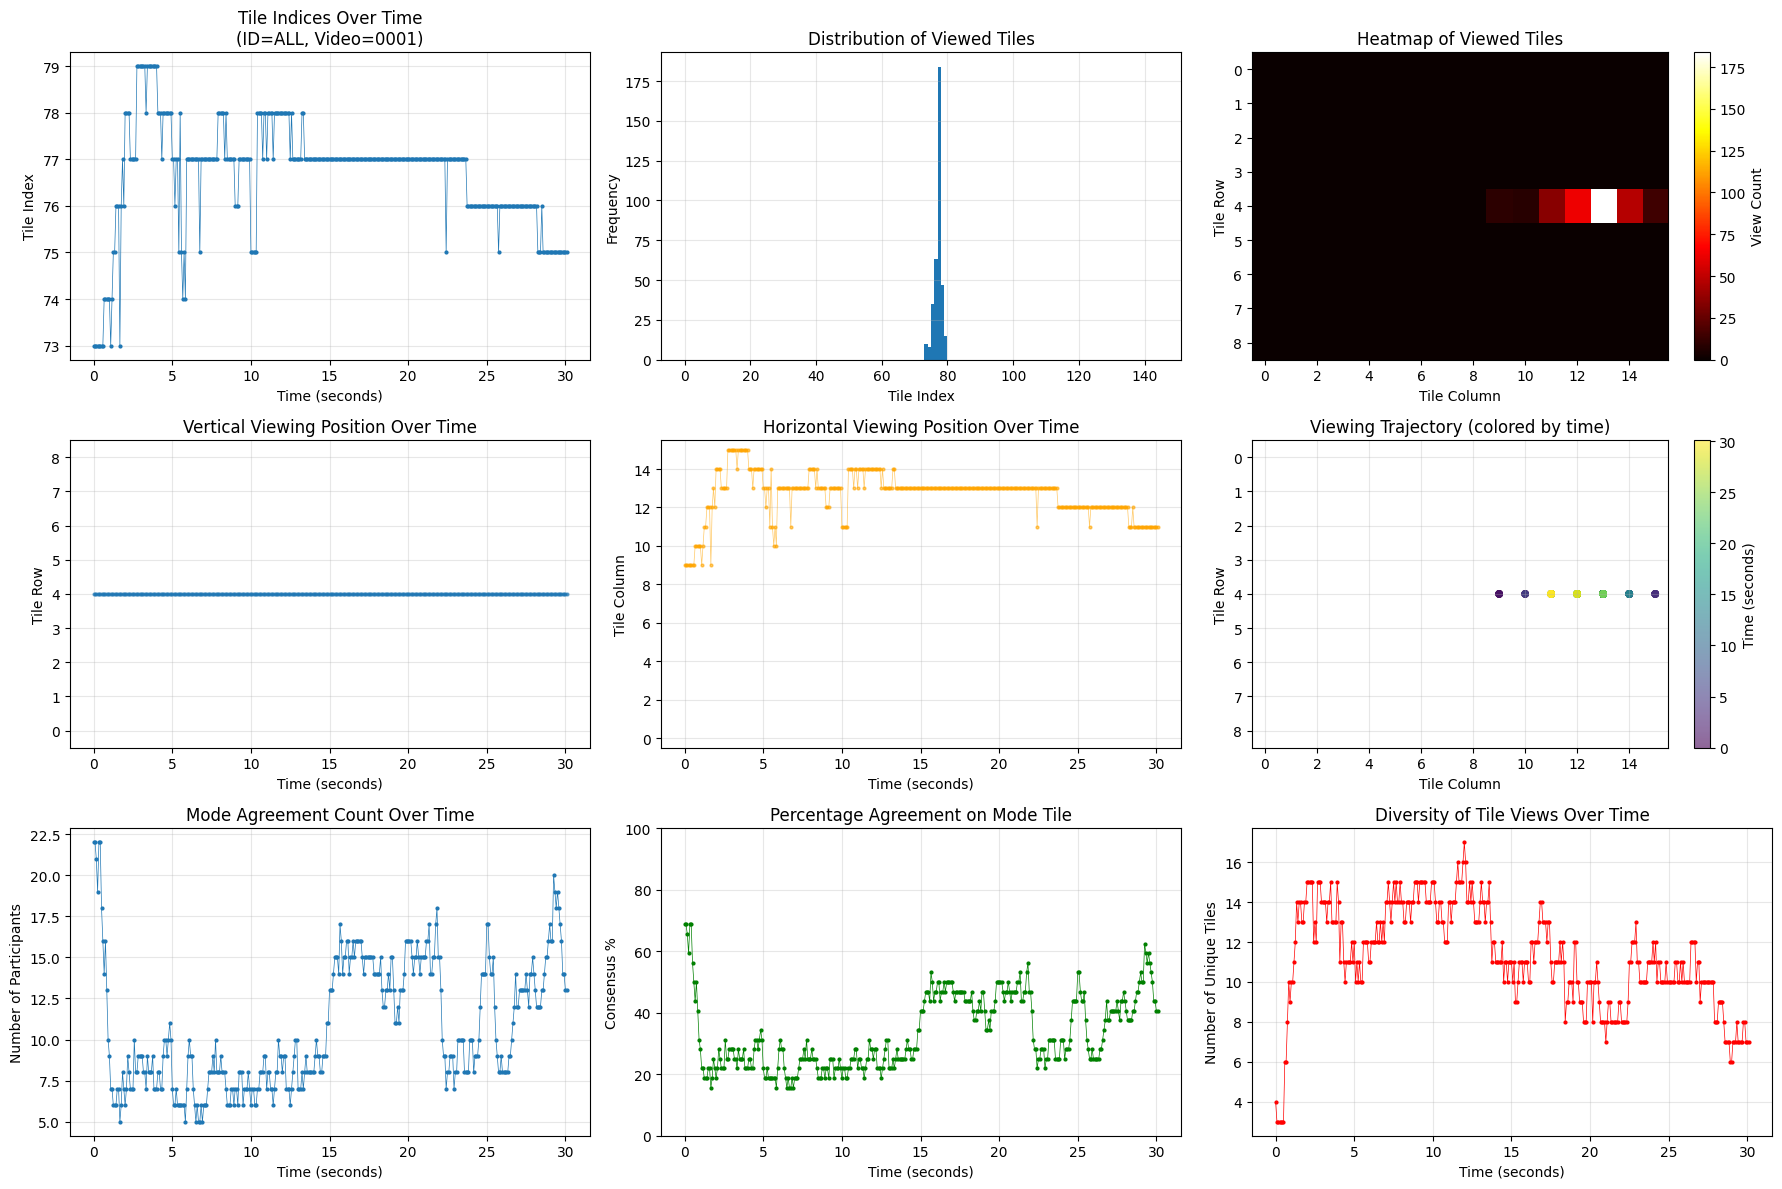


✓ Visualization complete for ID=ALL, Video=1


In [10]:
# ==================== VISUALIZE RESULTS (OPTIONAL) ====================
import matplotlib.pyplot as plt

print("="*70)
print("VISUALIZING HEAD TRACKING DATA")
print("="*70)

fig = plt.figure(figsize=(18, 12))

# Plot 1: Tile indices over time
plt.subplot(3, 3, 1)
plt.plot(timestamps, tile_indices, marker='o', markersize=2, linestyle='-', linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Index')
title_str = f'Tile Indices Over Time\n(ID={PARTICIPANT_ID}, Video={VIDEO_NAME:04d})'
plt.title(title_str)
plt.grid(True, alpha=0.3)

# Plot 2: Distribution histogram
plt.subplot(3, 3, 2)
plt.hist(tile_indices, bins=TILE_COLS * TILE_ROWS, range=(0, TILE_COLS * TILE_ROWS))
plt.xlabel('Tile Index')
plt.ylabel('Frequency')
plt.title('Distribution of Viewed Tiles')
plt.grid(True, alpha=0.3)

# Plot 3: Heatmap
plt.subplot(3, 3, 3)
tile_counts = np.bincount(tile_indices, minlength=TILE_COLS * TILE_ROWS)
heatmap = tile_counts.reshape(TILE_ROWS, TILE_COLS)
plt.imshow(heatmap, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='View Count')
plt.xlabel('Tile Column')
plt.ylabel('Tile Row')
plt.title('Heatmap of Viewed Tiles')
plt.xticks(range(0, TILE_COLS, 2))
plt.yticks(range(TILE_ROWS))

# Plot 4: Row distribution over time
plt.subplot(3, 3, 4)
rows, cols = tile_index_to_coords(tile_indices, TILE_COLS)
plt.plot(timestamps, rows, marker='o', markersize=2, linestyle='-', linewidth=0.5, alpha=0.6)
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Row')
plt.title('Vertical Viewing Position Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, TILE_ROWS - 0.5)

# Plot 5: Column distribution over time
plt.subplot(3, 3, 5)
plt.plot(timestamps, cols, marker='o', markersize=2, linestyle='-', linewidth=0.5, alpha=0.6, color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Tile Column')
plt.title('Horizontal Viewing Position Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(-0.5, TILE_COLS - 0.5)

# Plot 6: 2D trajectory
plt.subplot(3, 3, 6)
scatter = plt.scatter(cols, rows, c=timestamps, cmap='viridis', s=20, alpha=0.6)
plt.colorbar(scatter, label='Time (seconds)')
plt.xlabel('Tile Column')
plt.ylabel('Tile Row')
plt.title('Viewing Trajectory (colored by time)')
plt.xlim(-0.5, TILE_COLS - 0.5)
plt.ylim(TILE_ROWS - 0.5, -0.5)  # Invert y-axis to match screen coordinates
plt.grid(True, alpha=0.3)

# Additional plots for ALL mode
if participant_info is not None:
    # Plot 7: Mode count over time
    plt.subplot(3, 3, 7)
    mode_counts = [info['mode_count'] for info in participant_info]
    plt.plot(timestamps, mode_counts, marker='o', markersize=2, linestyle='-', linewidth=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Participants')
    plt.title('Mode Agreement Count Over Time')
    plt.grid(True, alpha=0.3)

    # Plot 8: Consensus percentage over time
    plt.subplot(3, 3, 8)
    consensus_pct = [info['mode_count'] / info['total_participants'] * 100
                     if info['total_participants'] > 0 else 0
                     for info in participant_info]
    plt.plot(timestamps, consensus_pct, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='green')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Consensus %')
    plt.title('Percentage Agreement on Mode Tile')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # Plot 9: Unique tiles viewed over time
    plt.subplot(3, 3, 9)
    unique_tiles = [info['unique_tiles_viewed'] for info in participant_info]
    plt.plot(timestamps, unique_tiles, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Unique Tiles')
    plt.title('Diversity of Tile Views Over Time')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete for ID={PARTICIPANT_ID}, Video={VIDEO_NAME}")

In [11]:
# ==================== EUCLIDEAN DISTANCE LOSS FUNCTION INFO ====================

print("="*70)
print("LOSS FUNCTION FOR YOUR CNN TRAINING")
print("="*70)

print("\nUse this Euclidean Distance Loss Function:")
print("-" * 70)
print("""
import numpy as np

def tile_distance_loss_euclidean(actual_indices, predicted_indices, cols=16):
    '''
    Calculate spatial distance loss for tile predictions

    Args:
        actual_indices: Ground truth tile indices
        predicted_indices: Predicted tile indices
        cols: Number of columns in tile grid (default: 16)

    Returns:
        loss: Mean Euclidean distance in tile coordinates
    '''
    # Convert tile indices to (row, col) coordinates
    actual_rows = actual_indices // cols
    actual_cols = actual_indices % cols
    pred_rows = predicted_indices // cols
    pred_cols = predicted_indices % cols

    # Calculate Euclidean distance
    distances = np.sqrt((actual_rows - pred_rows)**2 +
                       (actual_cols - pred_cols)**2)

    return np.mean(distances)
""")

print("\nWhy use this instead of simple index difference?")
print("-" * 70)
print("Example:")
print("  Actual tile:    67 (row 4, col 3)")
print("  Predicted tile: 83 (row 5, col 3)")
print()
print("  ❌ Naive loss: |67 - 83| = 16 (WRONG - misleading!)")
print("  ✓ Euclidean loss: √((4-5)² + (3-3)²) = 1.0 (CORRECT - 1 tile apart!)")
print()
print("The Euclidean loss correctly measures spatial distance on the 16x9 grid!")

LOSS FUNCTION FOR YOUR CNN TRAINING

Use this Euclidean Distance Loss Function:
----------------------------------------------------------------------

import numpy as np

def tile_distance_loss_euclidean(actual_indices, predicted_indices, cols=16):
    '''
    Calculate spatial distance loss for tile predictions

    Args:
        actual_indices: Ground truth tile indices
        predicted_indices: Predicted tile indices
        cols: Number of columns in tile grid (default: 16)

    Returns:
        loss: Mean Euclidean distance in tile coordinates
    '''
    # Convert tile indices to (row, col) coordinates
    actual_rows = actual_indices // cols
    actual_cols = actual_indices % cols
    pred_rows = predicted_indices // cols
    pred_cols = predicted_indices % cols

    # Calculate Euclidean distance
    distances = np.sqrt((actual_rows - pred_rows)**2 +
                       (actual_cols - pred_cols)**2)

    return np.mean(distances)


Why use this instead of simple index diff

CNN

In [13]:
# CNN init
    # take 9 heatmaps of a single frame
    # tile each into 16*9 tiles and label each tile with single index going per column from left to right, per row from top to bottom
    # convert into 3d matrix (each depth is a heatmap)
    # size of input matrix (16*pixWidthPerTile)*(9*pixHeightPerTile)*(3|4|5)
    # assume 4k consumer/customer market standard: 4k(3840x1920)
    # also take the head direction center and the corresponding tile's index for data per frame as input
    # we should be taking the 3d matrix of heatmaps and the tile index where the user is looking per frame as out data
    # predict the tile that the user will look at based on the heatmaps (weighted by each heatmap then fused) to find the tile with highest saliency
    # check the predicted tile index vs the actual inputted tile index for user view
    # loss/error function will be the difference in tile index hybrid with difference in tile coordinates to optimize by minimizing the loss
    # Hybrid Loss (30% CrossEntropy + 70% Euclidean):
    # do this per frame and get an accuracy as well as runtime calculation

In [ ]:
!pip install torch torchvision tqdm tabulate --quiet

import time, os, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tabulate import tabulate
from tqdm import tqdm
import gc

# Clear GPU memory
torch.cuda.empty_cache() if torch.cuda.is_available() else None

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")

# Configuration - 25% of 4K resolution
FRAME_WIDTH = 960    # 25% of 3840
FRAME_HEIGHT = 480   # 25% of 1920
TILES_X = 16
TILES_Y = 9
NUM_TILES = TILES_X * TILES_Y  # 144 tiles
TILE_WIDTH = FRAME_WIDTH // TILES_X   # 60 pixels
TILE_HEIGHT = FRAME_HEIGHT // TILES_Y  # ~53 pixels
NUM_HEATMAPS = 9  # 7 audio + 2 video

# Video configuration
FPS = 60  # Frames per second (full framerate)
VIDEO_DURATION = 3  # seconds
FRAME_SAMPLE_RATE = 5  # Take every 5th frame
TOTAL_FRAMES = FPS * VIDEO_DURATION  # 180 frames total for 3 seconds
FRAMES_PER_VIDEO = TOTAL_FRAMES // FRAME_SAMPLE_RATE  # 36 sampled frames


class TileCoordinateLoss(nn.Module):
    """
    Euclidean distance loss in tile coordinate space
    Instead of treating tiles as classes, measure spatial distance
    """
    def __init__(self, tiles_x=16, tiles_y=9):
        super(TileCoordinateLoss, self).__init__()
        self.tiles_x = tiles_x
        self.tiles_y = tiles_y

        # Precompute all tile coordinates for efficiency
        # Shape: (num_tiles, 2) where each row is [x, y]
        coords = []
        for tile_idx in range(tiles_x * tiles_y):
            y = tile_idx // tiles_x
            x = tile_idx % tiles_x
            coords.append([x, y])

        # Register as buffer (moved to device automatically)
        self.register_buffer('tile_coords', torch.tensor(coords, dtype=torch.float32))

    def forward(self, logits, target_indices):
        """
        Args:
            logits: (batch_size, num_tiles) - model outputs
            target_indices: (batch_size,) - ground truth tile indices

        Returns:
            loss: scalar - mean Euclidean distance in tile coordinates
        """
        batch_size = logits.size(0)

        # Get predicted tile indices (argmax)
        pred_indices = logits.argmax(dim=1)  # (batch_size,)

        # Convert indices to coordinates
        pred_coords = self.tile_coords[pred_indices]  # (batch_size, 2)
        target_coords = self.tile_coords[target_indices]  # (batch_size, 2)

        # Calculate Euclidean distance
        distances = torch.sqrt(
            (pred_coords[:, 0] - target_coords[:, 0])**2 +
            (pred_coords[:, 1] - target_coords[:, 1])**2
        )

        # Mean distance as loss
        return distances.mean()


class HybridTileLoss(nn.Module):
    """
    Combined loss: CrossEntropy for classification + Euclidean for spatial awareness
    """
    def __init__(self, tiles_x=16, tiles_y=9, ce_weight=0.7, coord_weight=0.3):
        super(HybridTileLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.coord_loss = TileCoordinateLoss(tiles_x, tiles_y)
        self.ce_weight = ce_wcoord_losseight
        self.coord_weight = coord_weight

    def forward(self, logits, target_indices):
        """
        Args:
            logits: (batch_size, num_tiles) - model outputs
            target_indices: (batch_size,) - ground truth tile indices

        Returns:
            total_loss: weighted combination of CE and coordinate loss
            ce_loss: cross entropy component
            coord_loss: coordinate distance component
        """
        ce = self.ce_loss(logits, target_indices)
        coord = self.coord_loss(logits, target_indices)

        total = self.ce_weight * ce + self.coord_weight * coord

        return total, ce, coord


class SaliencyTileDataset(Dataset):
    """Memory-efficient dataset for saliency heatmaps"""

    def __init__(self, heatmaps, tile_indices):
        """
        Args:
            heatmaps: numpy array of shape (N_frames, NUM_HEATMAPS, H, W)
            tile_indices: numpy array of shape (N_frames,) with tile indices [0-143]
        """
        # Convert to float32 for memory efficiency
        self.heatmaps = heatmaps.astype(np.float32)
        self.tile_indices = tile_indices.astype(np.int64)

    def __len__(self):
        return len(self.tile_indices)

    def __getitem__(self, idx):
        heatmap = torch.from_numpy(self.heatmaps[idx])
        tile_idx = torch.tensor(self.tile_indices[idx], dtype=torch.long)
        return heatmap, tile_idx


class HeatmapFusionCNN(nn.Module):
    """Lightweight CNN for fusing saliency heatmaps"""

    def __init__(self, num_heatmaps=9, num_tiles=144, dropout=0.3):
        super(HeatmapFusionCNN, self).__init__()

        # Heatmap fusion with 1x1 conv
        self.fusion = nn.Conv2d(num_heatmaps, 8, kernel_size=1)

        # Lightweight feature extraction
        self.conv1 = nn.Conv2d(8, 32, kernel_size=5, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Adaptive pooling
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        # Classifier
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_tiles)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Fuse heatmaps
        x = self.fusion(x)
        x = self.relu(x)

        # Feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        # Pool and classify
        x = self.pool(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


def tile_coords_to_index(x, y, tiles_x=TILES_X):
    """Convert tile coordinates to linear index"""
    return y * tiles_x + x


def tile_index_to_coords(idx, tiles_x=TILES_X):
    """Convert linear index to tile coordinates"""
    y = idx // tiles_x
    x = idx % tiles_x
    return x, y


def tile_distance(pred_idx, true_idx, tiles_x=TILES_X):
    """Calculate tile distance"""
    px, py = tile_index_to_coords(pred_idx, tiles_x)
    tx, ty = tile_index_to_coords(true_idx, tiles_x)
    return np.sqrt((px - tx)**2 + (py - ty)**2)


def train_epoch(model, dataloader, criterion, optimizer, device, use_hybrid=False):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_coord_loss = 0
    correct = 0
    total = 0

    for heatmaps, tile_indices in dataloader:
        heatmaps = heatmaps.to(device)
        tile_indices = tile_indices.to(device)

        optimizer.zero_grad()
        outputs = model(heatmaps)

        if use_hybrid:
            loss, ce_loss, coord_loss = criterion(outputs, tile_indices)
            total_ce_loss += ce_loss.item()
            total_coord_loss += coord_loss.item()
        else:
            loss = criterion(outputs, tile_indices)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += tile_indices.size(0)
        correct += predicted.eq(tile_indices).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    if use_hybrid:
        avg_ce = total_ce_loss / len(dataloader)
        avg_coord = total_coord_loss / len(dataloader)
        return avg_loss, accuracy, avg_ce, avg_coord
    else:
        return avg_loss, accuracy


def validate(model, dataloader, criterion, device, use_hybrid=False):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_ce_loss = 0
    total_coord_loss = 0
    correct = 0
    total = 0
    tile_distances = []

    with torch.no_grad():
        for heatmaps, tile_indices in dataloader:
            heatmaps = heatmaps.to(device)
            tile_indices = tile_indices.to(device)

            outputs = model(heatmaps)

            if use_hybrid:
                loss, ce_loss, coord_loss = criterion(outputs, tile_indices)
                total_ce_loss += ce_loss.item()
                total_coord_loss += coord_loss.item()
            else:
                loss = criterion(outputs, tile_indices)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += tile_indices.size(0)
            correct += predicted.eq(tile_indices).sum().item()

            for pred, true in zip(predicted.cpu().numpy(), tile_indices.cpu().numpy()):
                tile_distances.append(tile_distance(pred, true))

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    avg_distance = np.mean(tile_distances)

    if use_hybrid:
        avg_ce = total_ce_loss / len(dataloader)
        avg_coord = total_coord_loss / len(dataloader)
        return avg_loss, accuracy, avg_distance, avg_ce, avg_coord
    else:
        return avg_loss, accuracy, avg_distance


def generate_synthetic_video_data(num_videos=1):
    """
    Generate synthetic video data at 60 FPS, sampling every 5th frame

    Returns:
        heatmaps_4d: shape (num_videos, FRAMES_PER_VIDEO, NUM_HEATMAPS, H, W)
        tile_indices_1d: shape (num_videos, FRAMES_PER_VIDEO)
    """
    print(f"\n{'='*60}")
    print(f"Generating Synthetic Video Data")
    print(f"{'='*60}\n")
    print(f"Videos: {num_videos}")
    print(f"Duration: {VIDEO_DURATION}s @ {FPS} FPS = {TOTAL_FRAMES} total frames")
    print(f"Sampling: Every {FRAME_SAMPLE_RATE}th frame = {FRAMES_PER_VIDEO} sampled frames")
    print(f"Heatmap resolution: {FRAME_WIDTH}x{FRAME_HEIGHT} (25% of 4K)")
    print(f"Total sampled frames: {num_videos * FRAMES_PER_VIDEO}\n")

    # Initialize 4D matrix for heatmaps: (videos, sampled_frames, heatmaps, height, width)
    heatmaps_4d = np.zeros((num_videos, FRAMES_PER_VIDEO, NUM_HEATMAPS,
                            FRAME_HEIGHT, FRAME_WIDTH), dtype=np.float32)

    # Initialize 1D matrix for tile indices: (videos, sampled_frames)
    tile_indices_1d = np.zeros((num_videos, FRAMES_PER_VIDEO), dtype=np.int64)

    for video_idx in range(num_videos):
        print(f"Generating video {video_idx + 1}/{num_videos}...")

        # Create a smooth trajectory for the salient region across ALL frames
        start_x = np.random.randint(TILE_WIDTH * 2, FRAME_WIDTH - TILE_WIDTH * 2)
        start_y = np.random.randint(TILE_HEIGHT * 2, FRAME_HEIGHT - TILE_HEIGHT * 2)

        end_x = np.random.randint(TILE_WIDTH * 2, FRAME_WIDTH - TILE_WIDTH * 2)
        end_y = np.random.randint(TILE_HEIGHT * 2, FRAME_HEIGHT - TILE_HEIGHT * 2)

        # Create smooth trajectory for ALL 180 frames (60 FPS * 3 sec)
        trajectory_x = np.linspace(start_x, end_x, TOTAL_FRAMES)
        trajectory_y = np.linspace(start_y, end_y, TOTAL_FRAMES)

        # Add jitter
        jitter_x = np.random.randn(TOTAL_FRAMES) * (TILE_WIDTH / 4)
        jitter_y = np.random.randn(TOTAL_FRAMES) * (TILE_HEIGHT / 4)

        trajectory_x = np.clip(trajectory_x + jitter_x, 0, FRAME_WIDTH - 1)
        trajectory_y = np.clip(trajectory_y + jitter_y, 0, FRAME_HEIGHT - 1)

        # Sample every 5th frame
        sampled_frame_idx = 0
        for full_frame_idx in range(0, TOTAL_FRAMES, FRAME_SAMPLE_RATE):
            # Current center of attention at this frame
            cx = int(trajectory_x[full_frame_idx])
            cy = int(trajectory_y[full_frame_idx])

            # Generate heatmaps for this sampled frame
            fused_saliency = np.zeros((FRAME_HEIGHT, FRAME_WIDTH), dtype=np.float32)

            for heatmap_idx in range(NUM_HEATMAPS):
                # Random sigma for variety in saliency spread
                sigma = FRAME_WIDTH / (6 + np.random.rand() * 4)  # Varies between /6 and /10

                # Add small random offset for each heatmap
                offset_x = np.random.randint(-TILE_WIDTH//2, TILE_WIDTH//2)
                offset_y = np.random.randint(-TILE_HEIGHT//2, TILE_HEIGHT//2)

                center_x = np.clip(cx + offset_x, 0, FRAME_WIDTH - 1)
                center_y = np.clip(cy + offset_y, 0, FRAME_HEIGHT - 1)

                # Create Gaussian saliency map
                y, x = np.ogrid[:FRAME_HEIGHT, :FRAME_WIDTH]
                heatmap = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

                # Store heatmap
                heatmaps_4d[video_idx, sampled_frame_idx, heatmap_idx] = heatmap

                # Accumulate saliency (equal weight, let model learn optimal fusion)
                fused_saliency += heatmap

            # Find the tile with maximum saliency
            max_y, max_x = np.unravel_index(fused_saliency.argmax(), fused_saliency.shape)
            tile_x = min(max_x // TILE_WIDTH, TILES_X - 1)
            tile_y = min(max_y // TILE_HEIGHT, TILES_Y - 1)
            tile_idx = tile_coords_to_index(tile_x, tile_y)

            # Store tile index for this sampled frame
            tile_indices_1d[video_idx, sampled_frame_idx] = tile_idx

            sampled_frame_idx += 1

    print(f"\nData generation complete!")
    print(f"  Heatmaps 4D shape: {heatmaps_4d.shape}")
    print(f"  Tile indices shape: {tile_indices_1d.shape}")
    print(f"  Memory usage: {heatmaps_4d.nbytes / 1e6:.1f} MB\n")

    return heatmaps_4d, tile_indices_1d


def flatten_video_data(heatmaps_4d, tile_indices_1d):
    """
    Flatten video data from (videos, frames, ...) to (total_frames, ...)

    Args:
        heatmaps_4d: shape (num_videos, frames_per_video, num_heatmaps, H, W)
        tile_indices_1d: shape (num_videos, frames_per_video)

    Returns:
        heatmaps: shape (total_frames, num_heatmaps, H, W)
        tile_indices: shape (total_frames,)
    """
    num_videos, frames_per_video = tile_indices_1d.shape
    total_frames = num_videos * frames_per_video

    # Reshape heatmaps: (videos, frames, heatmaps, H, W) -> (total_frames, heatmaps, H, W)
    heatmaps = heatmaps_4d.reshape(total_frames, NUM_HEATMAPS, FRAME_HEIGHT, FRAME_WIDTH)

    # Flatten tile indices: (videos, frames) -> (total_frames,)
    tile_indices = tile_indices_1d.reshape(total_frames)

    return heatmaps, tile_indices


# Main execution
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print("360° Video Saliency-Based Tile Predictor")
    print("WITH EUCLIDEAN COORDINATE LOSS")
    print(f"{'='*60}\n")

    print(f"Configuration:")
    print(f"  Frame size: {FRAME_WIDTH}x{FRAME_HEIGHT} (25% of 4K)")
    print(f"  Grid: {TILES_X}x{TILES_Y} = {NUM_TILES} tiles")
    print(f"  Tile size: {TILE_WIDTH}x{TILE_HEIGHT}")
    print(f"  Heatmaps per frame: {NUM_HEATMAPS}")
    print(f"  Video: {VIDEO_DURATION}s @ {FPS}fps = {TOTAL_FRAMES} total frames")
    print(f"  Sampling: Every {FRAME_SAMPLE_RATE}th frame = {FRAMES_PER_VIDEO} sampled frames\n")

    # CHOOSE LOSS FUNCTION
    USE_HYBRID_LOSS = True  # Set to True for hybrid, False for pure coordinate loss

    if USE_HYBRID_LOSS:
        print("Loss Function: HYBRID (30% CrossEntropy + 70% Euclidean Coordinate)")
    else:
        print("Loss Function: PURE Euclidean Coordinate Distance")
    print()

    # Generate synthetic video data - just 1 video for memory efficiency
    num_videos = 1  # 1 video of 3 seconds
    heatmaps_4d, tile_indices_1d = generate_synthetic_video_data(num_videos=num_videos)

    print(f"{'='*60}")
    print("Data Structure:")
    print(f"{'='*60}")
    print(f"4D Heatmaps Matrix: {heatmaps_4d.shape}")
    print(f"  [videos, sampled_frames, heatmaps, height, width]")
    print(f"  [1, 36, 9, 480, 960]")
    print(f"  - 1 video")
    print(f"  - 36 sampled frames (every 5th frame from 180 total @ 60 FPS)")
    print(f"  - 9 heatmaps per frame (7 audio + 2 video)")
    print(f"  - 480x960 resolution (25% of 4K)")
    print(f"\n1D Tile Index Array: {tile_indices_1d.shape}")
    print(f"  [videos, sampled_frames]")
    print(f"  [1, 36]")
    print(f"  - 1 user's viewing data")
    print(f"  - 36 tile indices (sampled every 5th frame, range 0-143)")
    print(f"  - Each index represents which tile user is looking at")
    print(f"{'='*60}\n")

    # Flatten data for training
    heatmaps_flat, tile_indices_flat = flatten_video_data(heatmaps_4d, tile_indices_1d)

    print(f"Flattened for Training:")
    print(f"  Heatmaps: {heatmaps_flat.shape}")
    print(f"  Tile indices: {tile_indices_flat.shape}\n")

    # Create dataset
    dataset = SaliencyTileDataset(heatmaps_flat, tile_indices_flat)

    # Split
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

    print(f"Dataset splits:")
    print(f"  Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}\n")

    # Initialize model
    model = HeatmapFusionCNN(num_heatmaps=NUM_HEATMAPS, num_tiles=NUM_TILES).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}\n")

    # Initialize loss function
    if USE_HYBRID_LOSS:
        criterion = HybridTileLoss(tiles_x=TILES_X, tiles_y=TILES_Y,
                                   ce_weight=0.3, coord_weight=0.7).to(device)
    else:
        criterion = TileCoordinateLoss(tiles_x=TILES_X, tiles_y=TILES_Y).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training
    num_epochs = 15
    best_val_acc = 0
    results = []

    print("Training started...\n")
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        if USE_HYBRID_LOSS:
            train_loss, train_acc, train_ce, train_coord = train_epoch(
                model, train_loader, criterion, optimizer, device, use_hybrid=True)
            val_loss, val_acc, avg_tile_dist, val_ce, val_coord = validate(
                model, val_loader, criterion, device, use_hybrid=True)
        else:
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device, use_hybrid=False)
            val_loss, val_acc, avg_tile_dist = validate(
                model, val_loader, criterion, device, use_hybrid=False)

        scheduler.step(val_loss)
        epoch_time = time.time() - epoch_start

        if USE_HYBRID_LOSS:
            results.append([
                epoch + 1,
                f"{train_loss:.4f}",
                f"{train_acc:.1f}%",
                f"{val_loss:.4f}",
                f"{val_acc:.1f}%",
                f"{avg_tile_dist:.2f}",
                f"{val_ce:.4f}",
                f"{val_coord:.4f}",
                f"{epoch_time:.1f}s"
            ])
        else:
            results.append([
                epoch + 1,
                f"{train_loss:.4f}",
                f"{train_acc:.1f}%",
                f"{val_loss:.4f}",
                f"{val_acc:.1f}%",
                f"{avg_tile_dist:.2f}",
                f"{epoch_time:.1f}s"
            ])

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        if USE_HYBRID_LOSS:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train {train_acc:.1f}% | Val {val_acc:.1f}% | "
                  f"Dist {avg_tile_dist:.2f} | CE {val_ce:.4f} | Coord {val_coord:.4f} | {epoch_time:.1f}s")
        else:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train {train_acc:.1f}% | Val {val_acc:.1f}% | "
                  f"Dist {avg_tile_dist:.2f} | {epoch_time:.1f}s")

        # Clear cache periodically
        if epoch % 3 == 0 and device == "cuda":
            torch.cuda.empty_cache()

    total_time = time.time() - start_time

    # Test evaluation
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))

    if USE_HYBRID_LOSS:
        test_loss, test_acc, test_tile_dist, test_ce, test_coord = validate(
            model, test_loader, criterion, device, use_hybrid=True)
    else:
        test_loss, test_acc, test_tile_dist = validate(
            model, test_loader, criterion, device, use_hybrid=False)

    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"{'='*60}\n")

    print(f"Best Val Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Avg Tile Distance: {test_tile_dist:.2f} tiles")
    print(f"Total Training Time: {total_time:.1f}s ({total_time/60:.1f} min)\n")

    # Training history table
    if USE_HYBRID_LOSS:
        headers = ['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc',
                   'Tile Dist', 'Val CE', 'Val Coord', 'Time']
    else:
        headers = ['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'Tile Dist', 'Time']

    print(tabulate(results, headers=headers, tablefmt='simple'))

    # Inference speed test
    print(f"\n{'='*60}")
    print("Inference Speed Test")
    print(f"{'='*60}\n")

    model.eval()
    test_input = torch.randn(1, NUM_HEATMAPS, FRAME_HEIGHT, FRAME_WIDTH).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(test_input)

    # Measure
    if device == "cuda":
        torch.cuda.synchronize()

    inference_times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            output = model(test_input)
            if device == "cuda":
                torch.cuda.synchronize()
            inference_times.append(time.time() - start)

    avg_inf_ms = np.mean(inference_times) * 1000
    fps = 1000 / avg_inf_ms

    print(f"Average inference: {avg_inf_ms:.2f}ms")
    print(f"Throughput: {fps:.1f} FPS")
    print(f"Can process: {fps/FPS:.1f}x realtime")

    pred_tile = output.argmax(1).item()
    x, y = tile_index_to_coords(pred_tile)
    print(f"Sample prediction: Tile {pred_tile} at ({x}, {y})")

    print(f"\n{'='*60}")
    print("Model saved as 'best_model.pth'")
    print(f"{'='*60}\n")

    # Sample video analysis - show all sampled frames
    print(f"{'='*60}")
    print("User Viewing Data - Video 0 (3 seconds, every 5th frame)")
    print(f"{'='*60}")
    print(f"Sample# | Frame# | Time(s) | Tile Index | Tile Grid (x,y)")
    print(f"{'-'*60}")
    for i in range(FRAMES_PER_VIDEO):
        tile_idx = tile_indices_1d[0, i]
        tx, ty = tile_index_to_coords(tile_idx)
        actual_frame = i * FRAME_SAMPLE_RATE
        time_sec = actual_frame / FPS
        if i % max(1, FRAMES_PER_VIDEO//12) == 0:  # Show ~12 samples
          print(f"{i:7d} | {actual_frame:6d} | {time_sec:6.2f}  | {tile_idx:10d} | ({tx:2d}, {ty:2d})")
print(f"{'='*60}\n")

# Memory cleanup
del model, train_loader, val_loader, test_loader
gc.collect()
if device == "cuda":
    torch.cuda.empty_cache()
    print(f"GPU memory freed: {torch.cuda.memory_allocated()/1e9:.2f} GB in use")


Using device: cpu

360° Video Saliency-Based Tile Predictor
WITH EUCLIDEAN COORDINATE LOSS

Configuration:
  Frame size: 960x480 (25% of 4K)
  Grid: 16x9 = 144 tiles
  Tile size: 60x53
  Heatmaps per frame: 9
  Video: 3s @ 60fps = 180 total frames
  Sampling: Every 5th frame = 36 sampled frames

Loss Function: HYBRID (30% CrossEntropy + 70% Euclidean Coordinate)


Generating Synthetic Video Data

Videos: 1
Duration: 3s @ 60 FPS = 180 total frames
Sampling: Every 5th frame = 36 sampled frames
Heatmap resolution: 960x480 (25% of 4K)
Total sampled frames: 36

Generating video 1/1...

Data generation complete!
  Heatmaps 4D shape: (1, 36, 9, 480, 960)
  Tile indices shape: (1, 36)
  Memory usage: 597.2 MB

Data Structure:
4D Heatmaps Matrix: (1, 36, 9, 480, 960)
  [videos, sampled_frames, heatmaps, height, width]
  [1, 36, 9, 480, 960]
  - 1 video
  - 36 sampled frames (every 5th frame from 180 total @ 60 FPS)
  - 9 heatmaps per frame (7 audio + 2 video)
  - 480x960 resolution (25% of 4K)


Fetching Alg

VR FIELD OF VIEW (FoV) TILE FETCHING

VR Headset FoV:
  Horizontal: 110° (30.6% of 360°)
  Vertical: 90° (50.0% of 180°)

ERP Frame:
  Resolution: 960x480 pixels
  Grid: 16x9 tiles
  Tile size: 60x53 pixels

FoV Coverage:
  FoV size: 293x240 pixels
  FoV tiles: 5x5 tiles
  Total tiles per FoV: 25

DEMO: FoV Tile Fetching

Input: Predicted center tiles (1D array)
  [67 68 69 70 83 84 85 86 87]
  Shape: (9,)

Output: FoV tiles per frame (2D array/list of lists)
  Shape: (9, ~25)
  Each frame has ~25 tiles

Frame 0:
  Center tile: 67 at position (3, 4)
  FoV tiles (25 total): [33, 34, 35, 36, 37, 49, 50, 51, 52, 53]...

Frame 1:
  Center tile: 68 at position (4, 4)
  FoV tiles (25 total): [34, 35, 36, 37, 38, 50, 51, 52, 53, 54]...

Frame 2:
  Center tile: 69 at position (5, 4)
  FoV tiles (25 total): [35, 36, 37, 38, 39, 51, 52, 53, 54, 55]...


Visualizing Frame 0 FoV coverage...



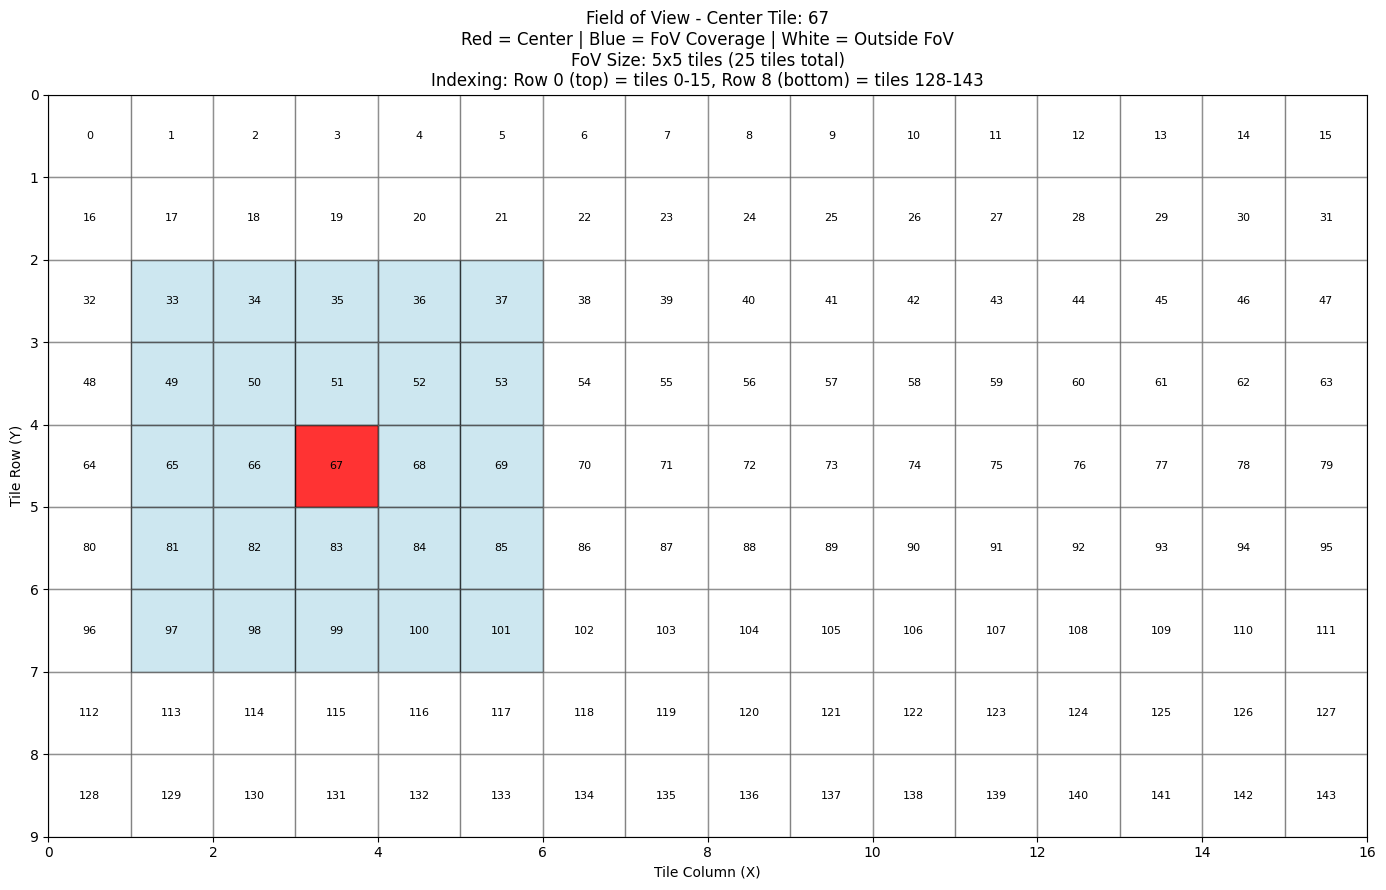

✓ FoV tiles saved to: fov_tiles_output.csv
  Format: frame_index, center_tile, num_fov_tiles, fov_tile_indices
  Frames: 9

FoV TILE FETCHING - USAGE SUMMARY

To use with your CNN predictions:

1. Get predictions from CNN (1D array of tile indices):
   predicted_tiles = [67, 68, 69, 70, ...]  # One per frame

2. Get FoV tiles for all frames:
   fov_tiles_2d = get_fov_tiles_batch(predicted_tiles)

3. Result is 2D array where each element is a list:
   fov_tiles_2d[0] = [67, 68, 69, 83, 84, ...]  # Frame 0's FoV tiles
   fov_tiles_2d[1] = [68, 69, 70, 84, 85, ...]  # Frame 1's FoV tiles

4. Use these tiles to fetch video data from server:
   - For each frame, fetch only the tiles in fov_tiles_2d[frame_idx]
   - This covers the entire FoV with some overlap at edges
   - ~25 tiles per frame instead of all 144 tiles

5. Parameters you can adjust:
   - HORIZONTAL_FOV_DEGREES: VR headset horizontal FoV (default: 110°)
   - VERTICAL_FOV_DEGREES: VR headset vertical FoV (default: 90°)
   - wrap

In [ ]:
# ==================== FIELD OF VIEW (FoV) TILE FETCHING ====================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# VR FoV Configuration
# Typical VR headset FoV: ~110° horizontal × ~90° vertical
# For 360° video: horizontal FoV = 110°/360° ≈ 30.6% of width
#                 vertical FoV = 90°/180° ≈ 50% of height

HORIZONTAL_FOV_DEGREES = 110  # degrees
VERTICAL_FOV_DEGREES = 90     # degrees

# ERP (Equirectangular Projection) covers 360° × 180°
ERP_HORIZONTAL_DEGREES = 360
ERP_VERTICAL_DEGREES = 180

# Calculate FoV as percentage of ERP frame
FOV_WIDTH_RATIO = HORIZONTAL_FOV_DEGREES / ERP_HORIZONTAL_DEGREES   # ~0.306 (30.6%)
FOV_HEIGHT_RATIO = VERTICAL_FOV_DEGREES / ERP_VERTICAL_DEGREES      # ~0.5 (50%)

# Frame and tile configuration (must match your CNN config)
FRAME_WIDTH = 960
FRAME_HEIGHT = 480
TILES_X = 16
TILES_Y = 9
TILE_WIDTH = FRAME_WIDTH // TILES_X   # 60 pixels
TILE_HEIGHT = FRAME_HEIGHT // TILES_Y  # ~53 pixels

# FoV dimensions in pixels
FOV_WIDTH_PIXELS = int(FRAME_WIDTH * FOV_WIDTH_RATIO)    # ~294 pixels
FOV_HEIGHT_PIXELS = int(FRAME_HEIGHT * FOV_HEIGHT_RATIO)  # ~240 pixels

# FoV dimensions in tiles (round up to ensure full coverage)
FOV_WIDTH_TILES = int(np.ceil(FOV_WIDTH_PIXELS / TILE_WIDTH))    # ~5 tiles
FOV_HEIGHT_TILES = int(np.ceil(FOV_HEIGHT_PIXELS / TILE_HEIGHT))  # ~5 tiles


print("="*70)
print("VR FIELD OF VIEW (FoV) TILE FETCHING")
print("="*70)
print(f"\nVR Headset FoV:")
print(f"  Horizontal: {HORIZONTAL_FOV_DEGREES}° ({FOV_WIDTH_RATIO*100:.1f}% of 360°)")
print(f"  Vertical: {VERTICAL_FOV_DEGREES}° ({FOV_HEIGHT_RATIO*100:.1f}% of 180°)")
print(f"\nERP Frame:")
print(f"  Resolution: {FRAME_WIDTH}x{FRAME_HEIGHT} pixels")
print(f"  Grid: {TILES_X}x{TILES_Y} tiles")
print(f"  Tile size: {TILE_WIDTH}x{TILE_HEIGHT} pixels")
print(f"\nFoV Coverage:")
print(f"  FoV size: {FOV_WIDTH_PIXELS}x{FOV_HEIGHT_PIXELS} pixels")
print(f"  FoV tiles: {FOV_WIDTH_TILES}x{FOV_HEIGHT_TILES} tiles")
print(f"  Total tiles per FoV: {FOV_WIDTH_TILES * FOV_HEIGHT_TILES}")
print("="*70 + "\n")

def tile_index_to_coords(tile_idx, tiles_x=TILES_X):
    """Convert tile index to (x, y) coordinates - TOP-TO-BOTTOM indexing"""
    row = tile_idx // tiles_x  # Row 0 is at TOP
    col = tile_idx % tiles_x
    return col, row  # Return (x, y) where y=0 is TOP


def tile_coords_to_index(x, y, tiles_x=TILES_X):
    """Convert (x, y) coordinates to tile index - TOP-TO-BOTTOM indexing"""
    return y * tiles_x + x  # y=0 is TOP row



def get_fov_tiles(center_tile_idx, tiles_x=TILES_X, tiles_y=TILES_Y,
                  fov_width_tiles=FOV_WIDTH_TILES, fov_height_tiles=FOV_HEIGHT_TILES,
                  wrap_horizontal=True):
    """
    Get all tiles within the Field of View centered on a given tile

    Args:
        center_tile_idx: Center tile index (0-143)
        tiles_x: Number of tiles horizontally (16)
        tiles_y: Number of tiles vertically (9)
        fov_width_tiles: FoV width in tiles (5)
        fov_height_tiles: FoV height in tiles (5)
        wrap_horizontal: Whether to wrap around horizontally (360° continuity)

    Returns:
        fov_tile_indices: List of tile indices within the FoV
    """
    # Get center tile coordinates
    center_x, center_y = tile_index_to_coords(center_tile_idx, tiles_x)

    # Calculate FoV bounds (centered on the tile)
    half_width = fov_width_tiles // 2
    half_height = fov_height_tiles // 2

    # For even-sized FoV, slightly favor the positive direction
    x_start = center_x - half_width
    x_end = center_x + half_width + (1 if fov_width_tiles % 2 == 1 else 0)

    y_start = center_y - half_height
    y_end = center_y + half_height + (1 if fov_height_tiles % 2 == 1 else 0)

    fov_tile_indices = []

    for y in range(y_start, y_end):
        for x in range(x_start, x_end):
            # Handle vertical bounds (clamp, no wrapping at poles)
            if y < 0:
                actual_y = 0
            elif y >= tiles_y:
                actual_y = tiles_y - 1
            else:
                actual_y = y

            # Handle horizontal bounds (wrap around for 360° continuity)
            if wrap_horizontal:
                actual_x = x % tiles_x  # Wrap around
            else:
                # Clamp without wrapping
                if x < 0:
                    actual_x = 0
                elif x >= tiles_x:
                    actual_x = tiles_x - 1
                else:
                    actual_x = x

            # Convert to tile index
            tile_idx = tile_coords_to_index(actual_x, actual_y, tiles_x)

            # Avoid duplicates (can happen at poles)
            if tile_idx not in fov_tile_indices:
                fov_tile_indices.append(tile_idx)

    return fov_tile_indices


def get_fov_tiles_batch(predicted_tile_indices, tiles_x=TILES_X, tiles_y=TILES_Y,
                        fov_width_tiles=FOV_WIDTH_TILES, fov_height_tiles=FOV_HEIGHT_TILES,
                        wrap_horizontal=True):
    """
    Get FoV tiles for multiple frames (batch processing)

    Args:
        predicted_tile_indices: 1D array of predicted center tile indices [tile0, tile1, ...]
                               Shape: (num_frames,)
        tiles_x, tiles_y: Grid dimensions
        fov_width_tiles, fov_height_tiles: FoV size in tiles
        wrap_horizontal: Whether to wrap horizontally

    Returns:
        fov_tiles_2d: 2D list where each element is a list of tile indices for that frame
                      Shape: (num_frames, ~25) where ~25 is FOV_WIDTH_TILES * FOV_HEIGHT_TILES
                      Example: [[67, 68, 69, ...], [68, 69, 70, ...], ...]
    """
    fov_tiles_2d = []

    for center_tile_idx in predicted_tile_indices:
        fov_tiles = get_fov_tiles(
            center_tile_idx=center_tile_idx,
            tiles_x=tiles_x,
            tiles_y=tiles_y,
            fov_width_tiles=fov_width_tiles,
            fov_height_tiles=fov_height_tiles,
            wrap_horizontal=wrap_horizontal
        )
        fov_tiles_2d.append(fov_tiles)

    return fov_tiles_2d

def visualize_fov_on_grid(center_tile_idx, fov_tile_indices, tiles_x=TILES_X, tiles_y=TILES_Y):
    """
    Visualize the FoV tiles on the grid (CORRECTED - top-to-bottom)
    """
    fig, ax = plt.subplots(figsize=(16, 9))

    # Draw grid - ROW 0 AT TOP
    for row in range(tiles_y):
        for col in range(tiles_x):
            tile_idx = tile_coords_to_index(col, row, tiles_x)

            # Color coding
            if tile_idx == center_tile_idx:
                color = 'red'
                alpha = 0.8
            elif tile_idx in fov_tile_indices:
                color = 'lightblue'
                alpha = 0.6
            else:
                color = 'white'
                alpha = 0.3

            # Draw rectangle (row 0 at top)
            rect = Rectangle((col, row), 1, 1,
                           linewidth=1, edgecolor='black',
                           facecolor=color, alpha=alpha)
            ax.add_patch(rect)

            # Add tile index
            ax.text(col + 0.5, row + 0.5, str(tile_idx),
                   ha='center', va='center', fontsize=8)

    # Configure plot
    ax.set_xlim(0, tiles_x)
    ax.set_ylim(0, tiles_y)
    ax.set_aspect('equal')
    ax.set_xlabel('Tile Column (X)')
    ax.set_ylabel('Tile Row (Y)')
    ax.set_title(f'Field of View - Center Tile: {center_tile_idx}\n'
                f'Red = Center | Blue = FoV Coverage | White = Outside FoV\n'
                f'FoV Size: {FOV_WIDTH_TILES}x{FOV_HEIGHT_TILES} tiles '
                f'({len(fov_tile_indices)} tiles total)\n'
                f'Indexing: Row 0 (top) = tiles 0-15, Row 8 (bottom) = tiles 128-143')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Invert so row 0 appears at top visually

    plt.tight_layout()
    plt.show()


def save_fov_tiles_to_csv(fov_tiles_2d, predicted_tile_indices, filename='fov_tiles_output.csv'):
    """
    Save FoV tiles to CSV file

    Args:
        fov_tiles_2d: 2D list of FoV tile indices per frame
        predicted_tile_indices: 1D array of center tile indices
        filename: Output CSV filename
    """
    import csv

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)

        # Write header
        writer.writerow(['frame_index', 'center_tile', 'num_fov_tiles', 'fov_tile_indices'])

        # Write data
        for frame_idx, (center_tile, fov_tiles) in enumerate(zip(predicted_tile_indices, fov_tiles_2d)):
            # Convert list of tiles to semicolon-separated string
            fov_tiles_str = ';'.join(map(str, fov_tiles))
            writer.writerow([frame_idx, center_tile, len(fov_tiles), fov_tiles_str])

    print(f"✓ FoV tiles saved to: {filename}")
    print(f"  Format: frame_index, center_tile, num_fov_tiles, fov_tile_indices")
    print(f"  Frames: {len(fov_tiles_2d)}")


# ==================== DEMO / TESTING ====================

print("="*70)
print("DEMO: FoV Tile Fetching")
print("="*70 + "\n")

# Example: Simulate predicted tiles from CNN (1D array)
# This would come from your CNN's predictions
example_predicted_tiles = np.array([67, 68, 69, 70, 83, 84, 85, 86, 87])  # 9 frames

print("Input: Predicted center tiles (1D array)")
print(f"  {example_predicted_tiles}")
print(f"  Shape: {example_predicted_tiles.shape}")
print()

# Get FoV tiles for all frames
fov_tiles_batch = get_fov_tiles_batch(example_predicted_tiles)

print("Output: FoV tiles per frame (2D array/list of lists)")
print(f"  Shape: ({len(fov_tiles_batch)}, ~{len(fov_tiles_batch[0])})")
print(f"  Each frame has ~{FOV_WIDTH_TILES * FOV_HEIGHT_TILES} tiles\n")

# Show first 3 frames in detail
for i in range(min(3, len(fov_tiles_batch))):
    center = example_predicted_tiles[i]
    fov_tiles = fov_tiles_batch[i]
    center_x, center_y = tile_index_to_coords(center)

    print(f"Frame {i}:")
    print(f"  Center tile: {center} at position ({center_x}, {center_y})")
    print(f"  FoV tiles ({len(fov_tiles)} total): {fov_tiles[:10]}{'...' if len(fov_tiles) > 10 else ''}")
    print()

# Visualize one example
print("\nVisualizing Frame 0 FoV coverage...\n")
visualize_fov_on_grid(
    center_tile_idx=example_predicted_tiles[0],
    fov_tile_indices=fov_tiles_batch[0]
)

# Save to CSV
save_fov_tiles_to_csv(fov_tiles_batch, example_predicted_tiles, 'fov_tiles_output.csv')

print("\n" + "="*70)
print("FoV TILE FETCHING - USAGE SUMMARY")
print("="*70)
print("""
To use with your CNN predictions:

1. Get predictions from CNN (1D array of tile indices):
   predicted_tiles = [67, 68, 69, 70, ...]  # One per frame

2. Get FoV tiles for all frames:
   fov_tiles_2d = get_fov_tiles_batch(predicted_tiles)

3. Result is 2D array where each element is a list:
   fov_tiles_2d[0] = [67, 68, 69, 83, 84, ...]  # Frame 0's FoV tiles
   fov_tiles_2d[1] = [68, 69, 70, 84, 85, ...]  # Frame 1's FoV tiles

4. Use these tiles to fetch video data from server:
   - For each frame, fetch only the tiles in fov_tiles_2d[frame_idx]
   - This covers the entire FoV with some overlap at edges
   - ~25 tiles per frame instead of all 144 tiles

5. Parameters you can adjust:
   - HORIZONTAL_FOV_DEGREES: VR headset horizontal FoV (default: 110°)
   - VERTICAL_FOV_DEGREES: VR headset vertical FoV (default: 90°)
   - wrap_horizontal: True for 360° wrapping, False to clamp at edges
""")
print("="*70)

# After CNN prediction
# predicted_tiles = model.predict(heatmaps)  # [67, 68, 69, ...]

# Get FoV tiles to fetch from server
# fov_tiles_2d = get_fov_tiles_batch(predicted_tiles)

# Now you have ~25 tiles per frame instead of 144!